<a href="https://colab.research.google.com/github/eitanfass/Tomato_quality/blob/main/main_code_tomato_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing and installing libraries


In [1]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 4.0 MB/s 


In [3]:
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns
import random
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from google.colab import drive
drive.mount('/content/drive')
# from sklearn import preprocessing
from sklearn.metrics import pairwise_distances_argmin,mean_squared_error,silhouette_score,r2_score

import pylab as pl
from sklearn import datasets, linear_model

from sklearn.preprocessing import StandardScaler
from scipy import stats
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline
from spectral import *
from skimage import io,measure, img_as_ubyte
import cv2
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import io
from scipy import ndimage as nd
'''
The imutils library is a series of convenience functions to make basic image processing functions such as translation,
rotation, resizing, skeletonization, and displaying Matplotlib images easier with OpenCV and Python 3.'''
import imutils


Mounted at /content/drive


#Creating classes:

In [4]:
global_band_table = pd.read_csv('/content/drive/MyDrive/Shared_tomato/Eitan/chennel chart.csv')
global wave_band_table,band_depth,R_wave,G_wave,B_wave
wave_band_table=np.array(global_band_table.loc[:,global_band_table.columns[-1]])
band_depth,R_wave,G_wave,B_wave=204,80,45,20
class Harvest():

    def __init__(self, tomato_shape, lab_results_path,reflectence_path):
      
      self.tomato_shape=tomato_shape
      self.lab_results=pd.read_csv(lab_results_path)
      self.cultivar,self.harvest_date=self._get_id()
      self.reflectence=pd.read_csv(reflectence_path)
      self.reflectence=self.reflectence.drop([self.reflectence.columns[0]],axis=1)
      self.reflectence=self.reflectence.T

    def _get_id(self):
      self.cultivar=self.lab_results.iloc[0][0].split('_')[0]
      self.harvest_date=self.lab_results.iloc[0][0].split('_')[1:4]
      return self.cultivar,self.harvest_date




class TomatoImage():
  
  def __init__(self,img_path, mask_path, bands_to_wave_table ,metadata=None,mask=None):
    self.img=self._load_img(img_path)#data type=
    self.mask=self.load_mask(mask_path)
    self.bands_to_waves= bands_to_wave_table
    self.metadata=metadata
  

  def spectral_to_RGB(self, img):
    global R_wave,G_wave,B_wave
    self.RGB=np.zeros([img.shape[0],img.shape[0],3],dtype=float)# create tamplate for RGB
    scaler=MinMaxScaler()
    self.RGB[:,:,0]=(img[:,:,R_wave]-img[:,:,R_wave].min())/(img[:,:,R_wave].max()-img[:,:,R_wave].min())#red 
    self.RGB[:,:,1]=(img[:,:,G_wave]-img[:,:,G_wave].min())/(img[:,:,G_wave].max()-img[:,:,G_wave].min())#green
    self.RGB[:,:,2]=(img[:,:,B_wave]-img[:,:,B_wave].min())/(img[:,:,B_wave].max()-img[:,:,B_wave].min())#blue
    #save as jpeg
    return self.RGB
  
  def _load_img(self,img_path):
    img = open_image(img_path)
    self.spectral=np.array(img.load())
    self.spectral=np.rot90(self.spectral[:,:,:],3)#rotate 
    self.RGB = self.spectral_to_RGB(self.spectral)
    return self.spectral

  def load_mask(self, mask_path):
    pass
  
class Tomato(Harvest):
    def __init__(self,lab_results,harvest:Harvest,tomato_id:int, reflectence,tomato_img=None):
      self.reflectence=reflectence
      self.lab_results=lab_results
      self.tomato_id=self.lab_results.iloc[0]
      self.harvest_date=harvest.harvest_date
      self.cultivar=harvest.cultivar
      if tomato_img==None:
        pass
      self.tomato_img=tomato_img
    def update_ref(self, reflectence):
      pass


class TomatoList():

  def __init__(self,harvest_list,tomato_img=None ,poligon_file=None ,):
    self.tomato_img=tomato_img
    self.harvest_list=harvest_list
    self.poligon_file=poligon_file
    self.tomato_dict=self._harvest_list_to_tomato_dict()
    self.tomato_list=self.creat_tomato_list(self.tomato_dict)
    self._harvest_list_to_df()
    self.cultivar_list=set([i.cultivar for i in self.harvest_list])
  def creat_tomato_list(self,tomato_dict):
    return [tomato_dict[i] for i in range(1,len(tomato_dict.keys())+1)]
  def _harvest_list_to_tomato_dict(self)->dict:
    tomato_dict={}
    key_count=1
    for i in self.harvest_list:
      temp=create_Tomato_instances(i)
      for j in range (key_count,(key_count+len(temp.keys()))):
        tomato_dict[j]=temp[j-key_count]
      key_count+=len(temp.keys())
    return tomato_dict
  def _harvest_list_to_df(self)->pd.DataFrame():
    global band_depth
    count=1
    all_tomatoes=pd.DataFrame()
    for i in self.harvest_list:
      new_index=np.arange(count,count+i.lab_results.shape[0])
      i.reflectence=i.reflectence.set_index(new_index)
      i.lab_results=i.lab_results.set_index(new_index)
      reflecttence_lab_results_df=pd.concat([i.reflectence,i.lab_results],axis=1)
      all_tomatoes=pd.concat([all_tomatoes,reflecttence_lab_results_df],axis=0)
      count+=i.lab_results.shape[0]
    self.tomato_df=all_tomatoes
    self.lab_results_df=all_tomatoes.loc[:,'Weight (g)':]
    self.np_reflectence=np.array(all_tomatoes.loc[:,:(band_depth-1)])
    self.reflectence_df=all_tomatoes.loc[:,:(band_depth-1)]
      
class TomatoFromImage():
    def __init__(self, harvest:Harvest,tomato_id, tomato_imgs, lab_results_path:str, reflectence:pd.DataFrame=None):
      self.reflectence=reflectence
      self.lab_results=pd.read_csv(self.lab_results_path)
      self.tomato_imgs=tomato_imgs
      self.harvest=harvest

      self.tomato_id=tomato_id

    def update_ref(self, reflectence):
      pass


In [5]:
def calc_stats_per_band(tomato_img):
  np_image_array = tomato_img.img
  band_depth=np_image_array.shape[2]
  stats={}
  mask=tomato_img.mask.flatten()
  for i in range(band_depth):
    flat=np_image_array[:,:,i].flatten()
    filterd = flat * mask
    filterd[mask==0]=None
    stats[i]= (flat.min(), flat.max() ,flat.mean() , np.median(flat) ,flat.std())
  return stats

def create_Tomato_instances(harvest:Harvest)->dict:
  '''function that gest a harvest
   object and creates tomato instences 
   in a dictionery with the key value the id'''
  T={}
  for i in range(harvest.lab_results.shape[0]):
    T[i]=Tomato(harvest.lab_results.iloc[i],harvest,i, harvest.reflectence.iloc[i])
  return T


def NI_model(tomato_list):
  ''' input TomatoList obj, 
  returns r_2,rmse colormaps dict with lab result parametrs as keys '''
  global band_depth
  r_2 = np.arange(band_depth*band_depth).reshape(band_depth, band_depth)
  r_2=np.float32(r_2)
  rmse =r_2.copy()
  spear=r_2.copy()
  R=r_2.copy()
  r_2_dict,R_dict, rmse_dict,spear_dict={},{},{},{}
  for col in tomato_list.lab_results_df.columns:
    temp_df=pd.concat([tomato_list.reflectence_df,tomato_list.lab_results_df[col]],axis=1)
    temp_df=temp_df[temp_df[col]>0].dropna(axis=0)
    np_results=np.array(temp_df[col])
    np_reflectence=np.array(temp_df.loc[:,:(band_depth-1)])
    for j in range(band_depth):#running all combinations
      for y in range(band_depth):
        NI=(np_reflectence[:,y]-np_reflectence[:,j])/(np_reflectence[:,y]+np_reflectence[:,j])
        slope, intercept, R[y,j], p_value, std_err = stats.linregress(NI,np_results) 
        r_2[y,j] =  R[y,j]**2
        rmse[y,j] =np.sqrt(((np_results-(intercept + (slope *NI)))**2).mean())
        spear[y,j],p_val= stats.spearmanr(NI, b=np_results)
        if j==y:
          r_2[y,j],R[y,j],spear[y,j],rmse[y,j]=0,0,0,0
    r_2_dict[col],R_dict[col], rmse_dict[col],spear_dict[col]=r_2,R,rmse,spear
  return r_2_dict,R_dict, rmse_dict,spear_dict

def plot_all_reflectence(tomato_list):# plots all reflectence data in the above format, wave df is requaired
  global global_band_table,band_depth
  fig, ax = plt.subplots(figsize=(10,7))
  df=tomato_list.reflectence_df.T
  x=list(np.arange(0,band_depth,50,dtype=int))
  for i in df.columns:
    ax.plot(df[i])
    plt.axvline(x=23,color='b',lw=5)
    plt.axvline(x=47,color='g',lw=5)
    plt.axvline(x=80,color='r',lw=5)
  ax.set(xlabel='Wavelangth (nm)',
        ylabel='Reflectence'
        )
  plt.xticks(ticks=x, labels =global_band_table.loc[x]['wavelangth']//10*10)


def plot_colormaps(map_dict:dict,stat_name:str)->dict:
  global global_band_table
  waves=[float(i) for i in global_band_table['wavelangth'] ]
  colormaps=[cm.get_cmap('viridis', 256)]
  for key,map in map_dict.items():
    data = pd.DataFrame(data=map,index=waves,columns=waves)
    n = len(colormaps)
    mask =  np.tri(data.shape[0], k=-1)
    data= np.ma.array(data, mask=mask)
    fig, axs = plt.subplots(1,n, figsize=(10, 10),
                constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):   
        psm = ax.pcolormesh(waves,waves,data, cmap=cmap, rasterized=True, vmin=data[~np.isnan(data)].min(), vmax=data[~np.isnan(data)].max())
        fig.colorbar(psm, ax=ax)
    plt.title(f'{stat_name} of normalized index with {key}')
    plt.xlabel('Band 1 (nm)')
    plt.ylabel('Band 2 (nm)')
    plt.show()


def plot_all_color_maps(r_2=None,R=None,rmse=None,spear=None):
  '''helper function to plot colormaps of all stats R, R^2, rmse and spearman 
  recieves colormap_dict'''
  if R!=None:
    plot_colormaps(R,'R')
  if r_2!=None:
    plot_colormaps(r_2,'R^2')
  if rmse!=None:
    plot_colormaps(rmse,'RMSE')
  if spear!=None:
    plot_colormaps(spear,'Spearsman corolation')

def max_bands_from_colormaps(map_dict:dict,number_of_max_values=3)->dict:
  '''function thar receives a colormap
   and the number of max value and finds
    the band combination for them'''
  bands={}
  for k,v in map_dict.items():
    for i in range(1,number_of_max_values+1):
      bands[f'{k}-max {i}']= np.unravel_index(map.argmax(), map.shape)
      map[bands[f'{k}-max {i}'][0],bands[f'{k}-max {i}'][1]]=0
  return bands

def regretionplot(tomato_list,map_dict=None,number_of_max_values=1):
  '''creats a regretssion plot,
   colors the samples by their red index values from green to red,
    data_dict in format of add_res_to_ref function'''
  global global_band_table,R_wave,G_wave,band_depth
  if map_dict==None:
    b1,b2=R_wave,G_wave
  else:bands=max_bands_from_colormaps(map_dict,number_of_max_values)
  waves=[float(i) for i in global_band_table['wavelangth'] ]
  palette = {1:"lime",2:"orange",3:"tomato",4:"red"}#,2:"orangered",4:"darkorange",6:"gold"
  for col in tomato_list.tomato_df.loc[:,'Weight (g)':].columns:#loop on the columns names of results
    temp_df=pd.concat([tomato_list.tomato_df.loc[:,:(band_depth-1)],tomato_list.tomato_df[col]],axis=1)
    temp_df=temp_df[temp_df[col]>0].dropna(axis=0)
    np_results=np.array(temp_df[col])# created a clean np array of results with no nan None or negetive values
    np_reflectence=np.array(temp_df.loc[:,:(band_depth-1)])
    for i in range(1,number_of_max_values+1):
      if map_dict!=None:
        b1,b2=bands[f'{col}-max {i}']
      NI=((np_reflectence[:,b1]-np_reflectence[:,b2])/(np_reflectence[:,b1]+np_reflectence[:,b2]))
      red_index=(np_reflectence[:,80]-np_reflectence[:,40])/(np_reflectence[:,80]+np_reflectence[:,40])#getting a red index value for all samples
      color=red_index-red_index.min()
      num=(color.max()/4)+0.00001
      color=(color//num)+1#color of all samples in pallette keys as colors
      x_tag=  'NI'
      data_dict={x_tag:NI ,col:np_results, 'Color':color}
      data=pd.DataFrame(data_dict)
      slope, intercept, r_value, p_value, std_err = stats.linregress(data[x_tag],data[col])
      sns.lmplot(x=x_tag, y=col, hue="Color", data=data,palette=palette, fit_reg=False, legend=False)#x_estimator=np.mean
      plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':100})
      ax = sns.regplot(x=x_tag , y=col, data=data, scatter_kws={"zorder":-1}, line_kws={'color': 'black','label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
      ax.text(0.18, 1.05, "R=: {:.2f}   P-value= {:.4f} ".format(r_value,p_value), ha="left", va="top",fontsize=15, transform=ax.transAxes)
      ax.text(0.20, 1, "bands=({:.0f}nm,{:.0f}nm)".format(waves[b1],waves[b2]), ha="left", va="top",fontsize=15, transform=ax.transAxes)
    # plt.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
def get_color_groups(tomato_list,color_groups:int=3)->pd.DataFrame():# helper function to get color groups for plotting
  global band_depth,R_wave,G_wave
  np_ref=np.array(tomato_list.tomato_df.loc[:,:(band_depth-1)])
  l=(np_ref[:,R_wave]-np_ref[:,G_wave])/(np_ref[:,R_wave]+np_ref[:,G_wave])
  ref_new=tomato_list.tomato_df.loc[:,:(band_depth-1)]
  ref_new['Red Index']=l
  l1=l-l.min()
  lab_results=tomato_list.tomato_df.loc[:,'Weight (g)':]
  lab_results['Red Index']=l1
  num=(l1.max()/color_groups)+0.00001
  l1=(l1//num)+1
  lab_results['sample']=range(np_ref.shape[0])
  sorted_by_color=lab_results.sort_values(by=['Red Index'])
  sorted_by_color['color']=range(np_ref.shape[0])
  sorted_by_color['color']=sorted_by_color['color']//(np_ref.shape[0]/color_groups)+1
  final_df=sorted_by_color.sort_values(by=['sample'])
  final_df=final_df.drop(['Red Index','sample'],axis=1)
  return final_df


TODO to sync the old functions with the find color function.

#histogram functions

In [6]:
def histogram_by_color(tomato_list,col,color_grups=3 ,palette=['lime','orange','r']):# TODO make a few paletts for user to call optinal
  if color_grups!=len(palette):
    print('palette and color groups must match')
    return
  n=color_grups
  data=get_color_groups(tomato_list,n)
  data=data[data[col]>0]
  start=data[col].min()
  end=data[col].max()
  step=(end-start)/10
  fig, ax = plt.subplots(1,  figsize=(10,7))
  for i,c in zip(range(n),palette):
    
    bins=np.arange(start,end+step,step)
    start+=step/n
    end+=step/n
    c_grup=data[col][data['color']==(i+1)]
    ax.hist(c_grup,color=c,label=f"n={len(c_grup)} STD={c_grup.std():.2f} Mean={c_grup.mean():.1f}" ,bins=bins,width=step/n)
  ax.set_xlabel(col, fontsize = 20)
  ax.set_ylabel('number of samples', fontsize = 20)
  ax.set_title(f'groups 1-{n} {col} distrubution\n N={len(data[col])} STD={data[col].std():.2f} Mean={data[col].mean():.1f}', fontsize = 25)
  ax.legend(fontsize=15)

def histograms(tomato_list, color_grups=3 ,palette=['lime','orange','r']):
  for col in tomato_list.lab_results_df.columns:
    histogram_by_color(tomato_list,col,color_grups ,palette)



In [7]:
data=tomato_list.lab_results_df
for col in data.columns:
  data_range=data[col].max()-data[col].min()
  step=data_range/4
  for i in range(data[col].min(),data[col].max(),step):


SyntaxError: ignored

#Image prossecing

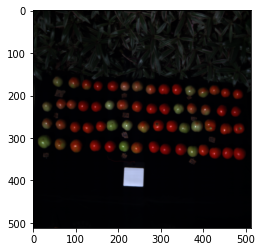

In [9]:
hdr_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/22_6_22/SOLI_256/Spectral/RAW_SPECTRAL_DATA/22_6_22 SOLI/1373/results/REFLECTANCE_1373.hdr'
soli_sideA=TomatoImage(hdr_path,hdr_path,global_band_table)
hdr_path='/content/drive/MyDrive/71254_2023/02_Assignment_Submission/Eitan.Fass/HW04/images/results/REFLECTANCE_1452.hdr'
harvest_4=TomatoImage(hdr_path,hdr_path,global_band_table)
plt.imshow(harvest_4.RGB)


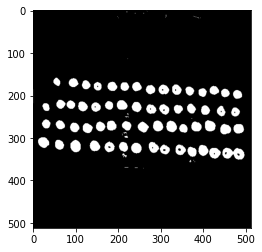

In [10]:

img=(harvest_4.RGB*255).astype('uint8')
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # convert rgb to hsv


mask = cv2.inRange(hsv, (0,30,50), (50,255,255)) # mask out the green balls. range of hsv. from hsv1 to hsv2. 
# enter the link to see the hsv color space
# https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv/48367205#48367205
# we chose only h and s. v we made same as s
closed_mask = nd.binary_closing(mask, np.ones((3,2)))
# display our mask
plt.imshow(closed_mask,cmap='gray')



<ipython-input-16-1c8875d5f255>:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(-D, indices=False, min_distance=10,


[INFO] 266 unique segments found


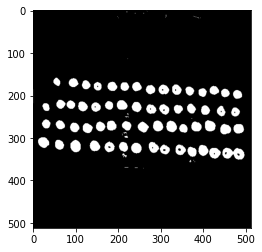

In [16]:

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = nd.distance_transform_edt(closed_mask)

# Now we take D , our distance map, and find peaks (i.e., local maxima) in the map. We’ll ensure that is at least a 20 pixel distance between each peak.
localMax = peak_local_max(-D, indices=False, min_distance=10,
	labels=closed_mask)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = nd.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=closed_mask) #  matrix of labels
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # color to gray

# loop over the unique labels returned by the Watershed algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue

	# otherwise, allocate memory for the label region, and set the pixels belonging to the current label to 255 (white). draw it on the mask.
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255

	# detect contours in the mask and grab the largest one — this contour will represent the outline/boundary of a given object in the image.
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
 
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(img, (int(x), int(y)), int(r), (0, 255, 0), 1)
	cv2.putText(img, "#{}".format(label), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
 
# show the output image
plt.imshow(harvest_4.RGB)
# display our mask
plt.imshow(closed_mask,cmap='gray')

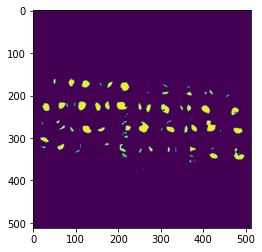

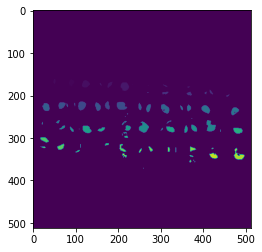

In [12]:

nir_img=soli_sideA.spectral[:,:,110].copy()
nir_img[nir_img>0.5]=1
nir_img[nir_img<=0.5]=0

nir_img = nd.binary_closing(nir_img, np.ones((5,5)))
new_mask=nir_img*closed_mask
plt.imshow(new_mask)
plt.show()
# lets label our blue balls, each one will get a different color
label_image = measure.label(new_mask)
plt.imshow(label_image)

In [14]:
from skimage.color import label2rgb
image_label_overlay = label2rgb(label_image, image=harvest_4.RGB) # display the labels, abovee our original iamge (img)
# plt.imshow(image_label_overlay)

# lets get info about the blue balls (using measure)

props = measure.regionprops_table(label_image, img,
                                  properties= ['label',
                                               'area', 'equivalent_diameter', 
                                               'mean_intensity', 'solidity'])


df = pd.DataFrame(props)
df1=df[df['area']>100]
df1

<ipython-input-14-9a1420cd64a9>:2: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_label_overlay = label2rgb(label_image, image=harvest_4.RGB) # display the labels, abovee our original iamge (img)


,label,area,equivalent_diameter,mean_intensity-0,mean_intensity-1,mean_intensity-2,solidity
0,1,163,14.406181,25.122699,39.122699,154.993865,0.905556
2,3,236,17.334490,34.766949,19.686441,151.601695,0.963265
4,5,308,19.802974,46.795455,50.431818,117.785714,0.944785
16,17,145,13.587484,27.737931,43.572414,187.172414,0.935484
17,18,291,19.248707,44.422680,15.773196,126.498282,0.950980
18,19,333,20.590988,53.240240,43.807808,103.450450,0.938028
19,20,190,15.553633,48.210526,42.063158,106.068421,0.954774
20,21,181,15.180789,59.254144,25.867403,66.657459,0.937824
23,24,231,17.149879,32.502165,50.497835,138.969697,0.942857
25,26,137,13.207340,30.116788,30.890511,157.357664,0.938356


#applying classes to data

In [10]:
harvest_1_lab_results_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2021/2021_08_15/LEKET/Lab/2021_08_15_LEKET_ID1_27.csv'
harvest_1_reflectence_path="/content/drive/MyDrive/Shared_tomato/Eitan/LEKET_FARM_15_08_2021/SPECTRAL_DATA/reflectence_mean_ID1_27.csv"
harvest_1=Harvest('Roma',harvest_1_lab_results_path,harvest_1_reflectence_path)

In [11]:
harvest_2_lab_results_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2021/2021_10_13/ROMA_AS200/Lab/2021_10_13 _ROMA_AS200_ID1_320_All.csv'
harvest_2_reflectence_path='/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/SPECTRAL_DATA/Reflectence_ID1_320.csv'
harvest_2=Harvest('Roma',harvest_2_lab_results_path,harvest_2_reflectence_path)

In [12]:
harvest_3_lab_results_path="/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/22_6_22/SOLI_256/Lab/chemical_results_soli_id_1_40.csv"
harvest_3_reflectence_path="/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/22_6_22/SOLI_256/Spectral/2022_6_22_SOLI_Medien_ID1_40.csv"
harvest_3=Harvest('Singel Round',harvest_3_lab_results_path,harvest_3_reflectence_path)


In [13]:
harvest_4_reflectence_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/19_10_22/SOLI_industrial/Spectral/Lab_Images/2022_10_19_SOLI_industial_Mean_ID1_60.csv'
harvest_4_lab_results_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/19_10_22/SOLI_industrial/Lab/2022_10_19_Chemical_Results_SOLI_industrial_ID1_60.csv'
harvest_4=Harvest('Clusters Round',harvest_4_lab_results_path,harvest_4_reflectence_path)


In [14]:
tomato_list=TomatoList([harvest_1,harvest_2,harvest_3,harvest_4])#create TomatoList object

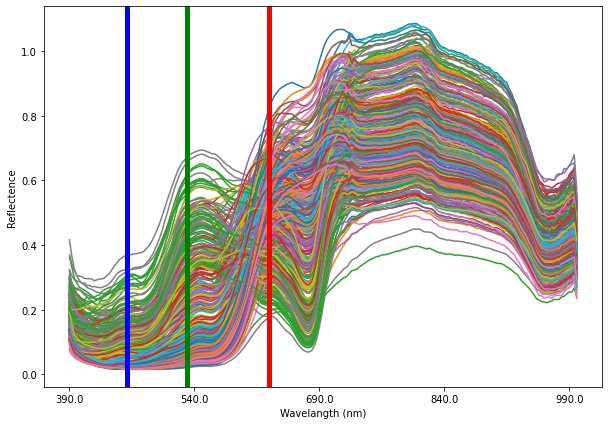

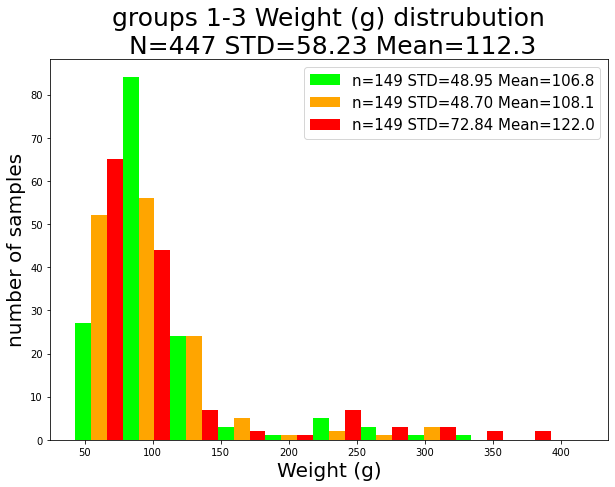

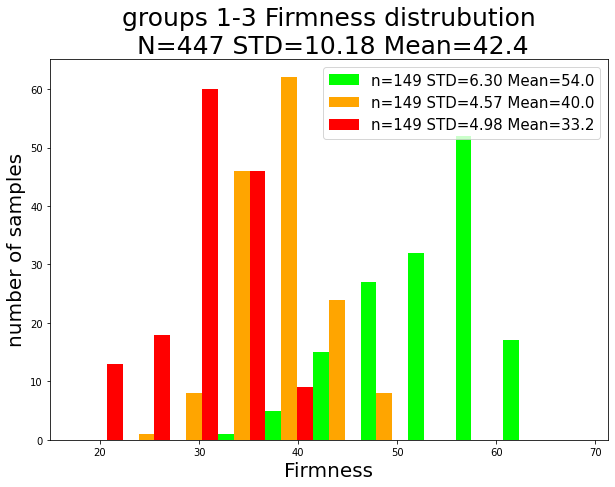

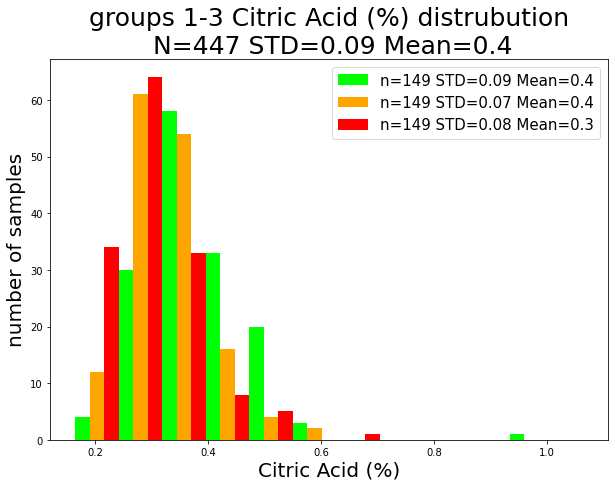

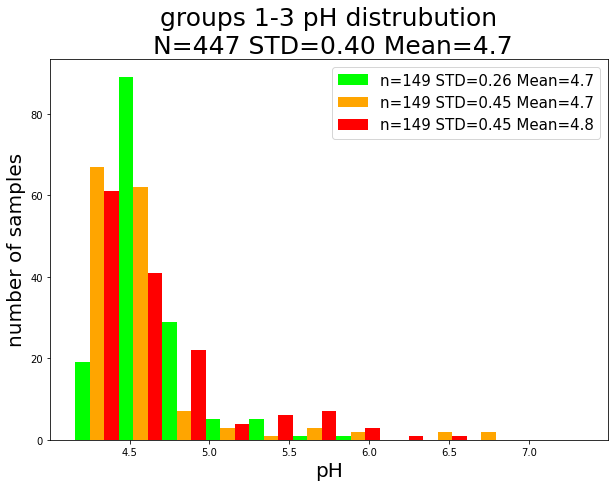

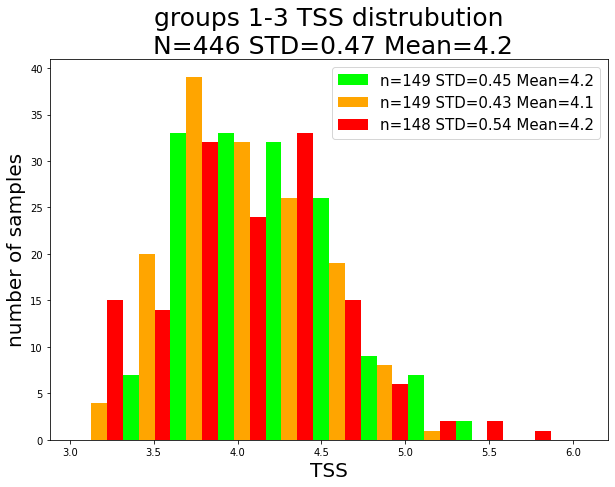

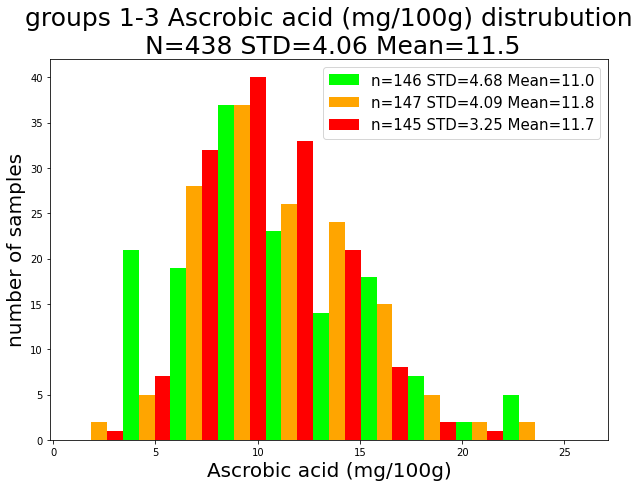

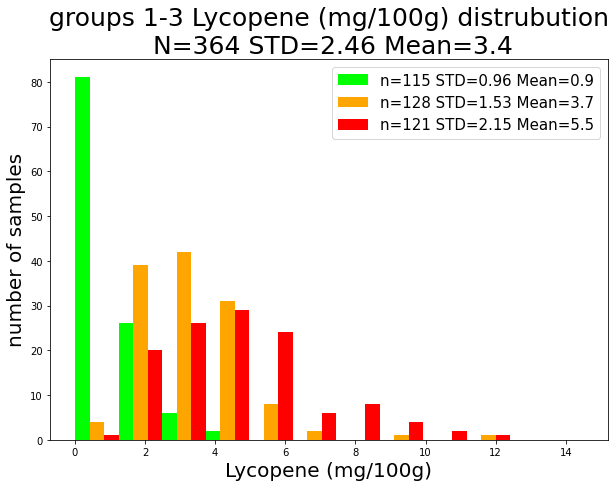

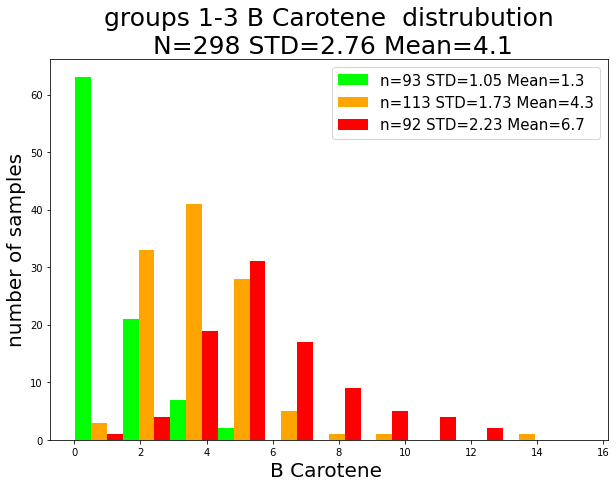

In [15]:
plot_all_reflectence(tomato_list)
histograms(tomato_list)

In [ ]:

fig, ax = plt.subplots(figsize=(10,7))
df=tomato_list.reflectence_df.T
x=list(np.arange(0,band_depth,50,dtype=int))
for i in df.columns:
  ax.plot(df[i])
  plt.axvline(x=23,color='b',lw=5)
  plt.axvline(x=47,color='g',lw=5)
  plt.axvline(x=80,color='r',lw=5)
ax.set(xlabel='Wavelangth (nm)',
      ylabel='Reflectence'
      )
plt.xticks(ticks=x, labels =global_band_table.loc[x]['wavelangth']//10*10)



#colormaps NI model

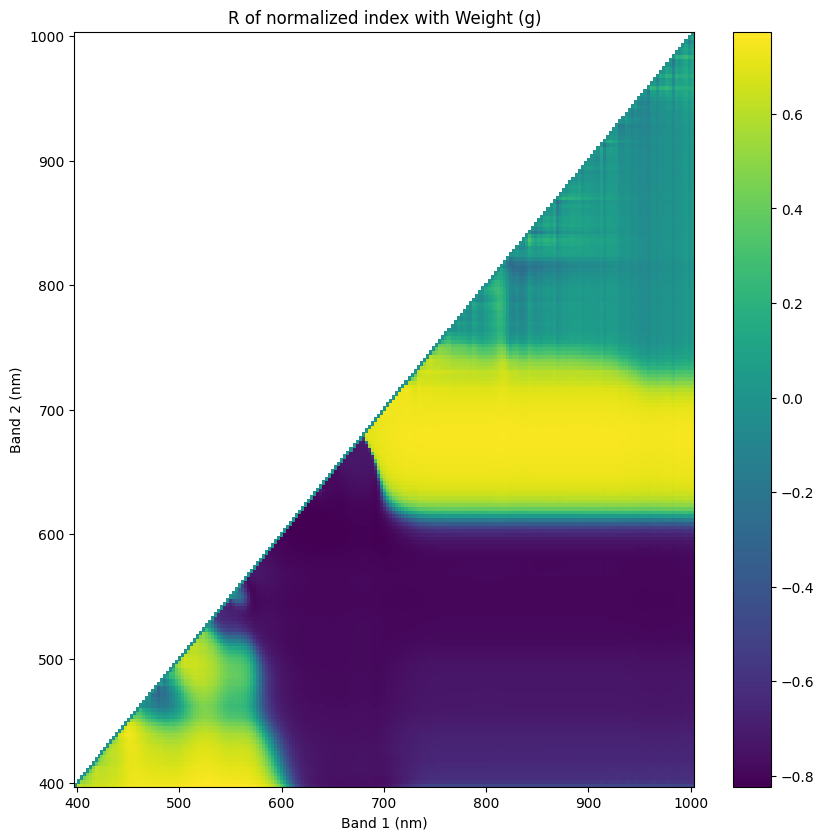

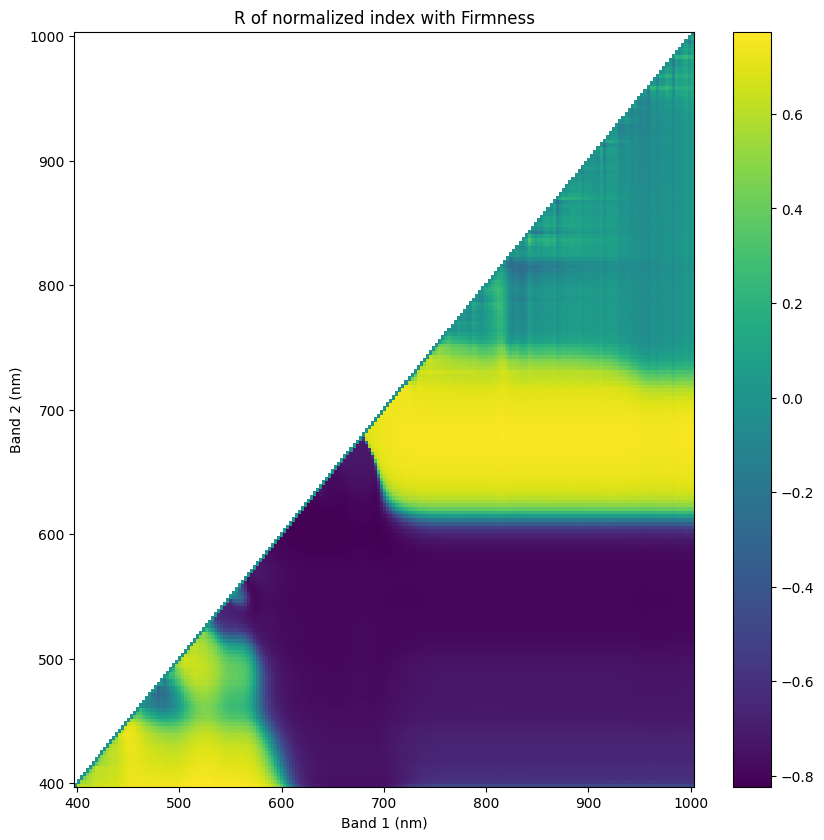

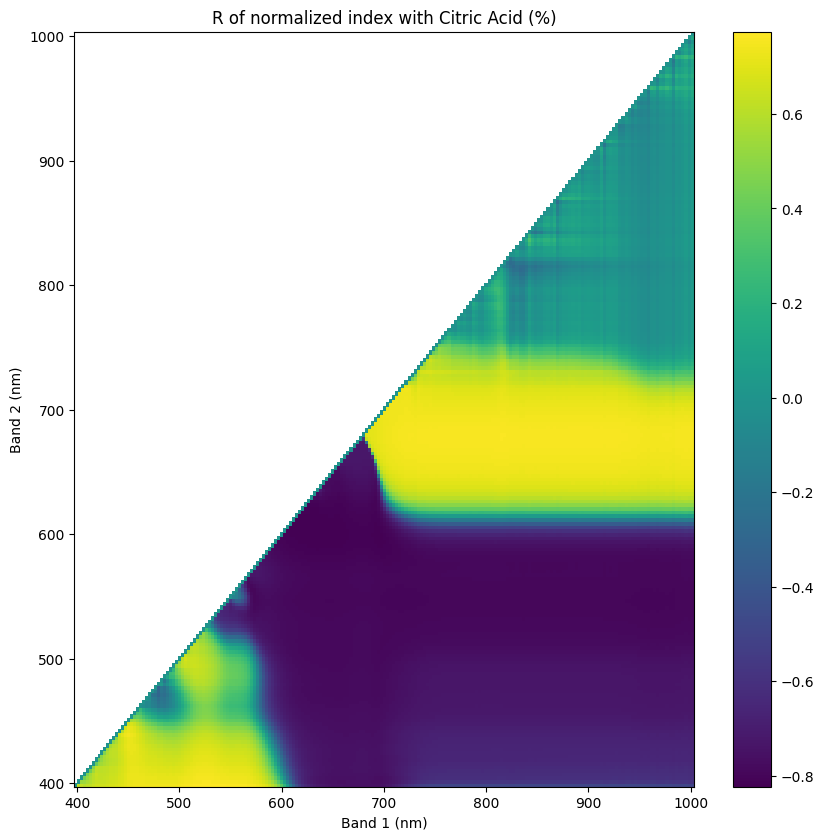

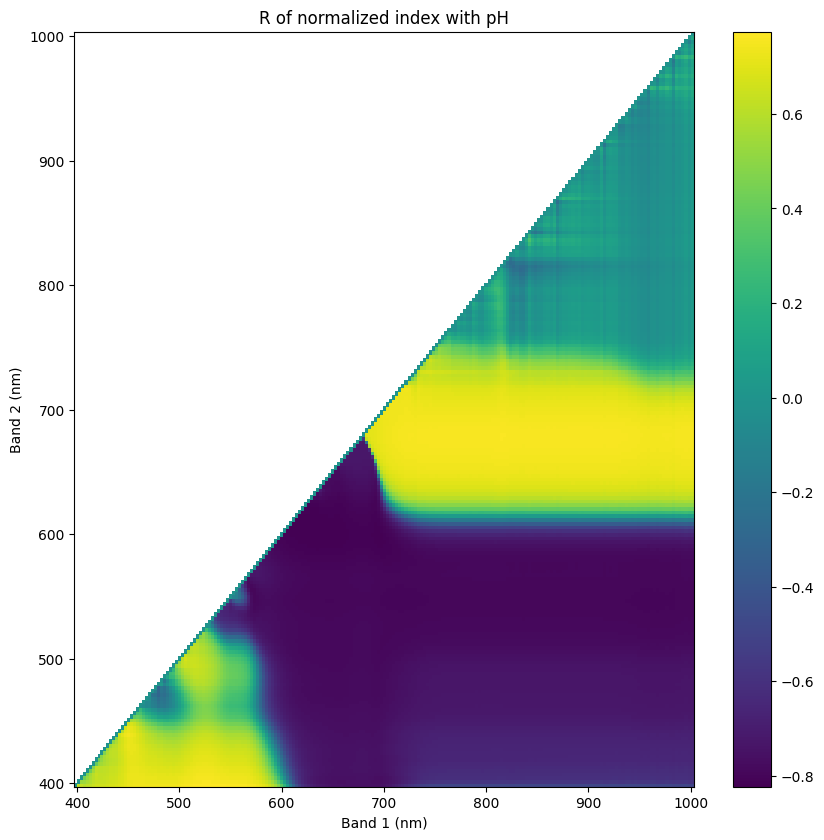

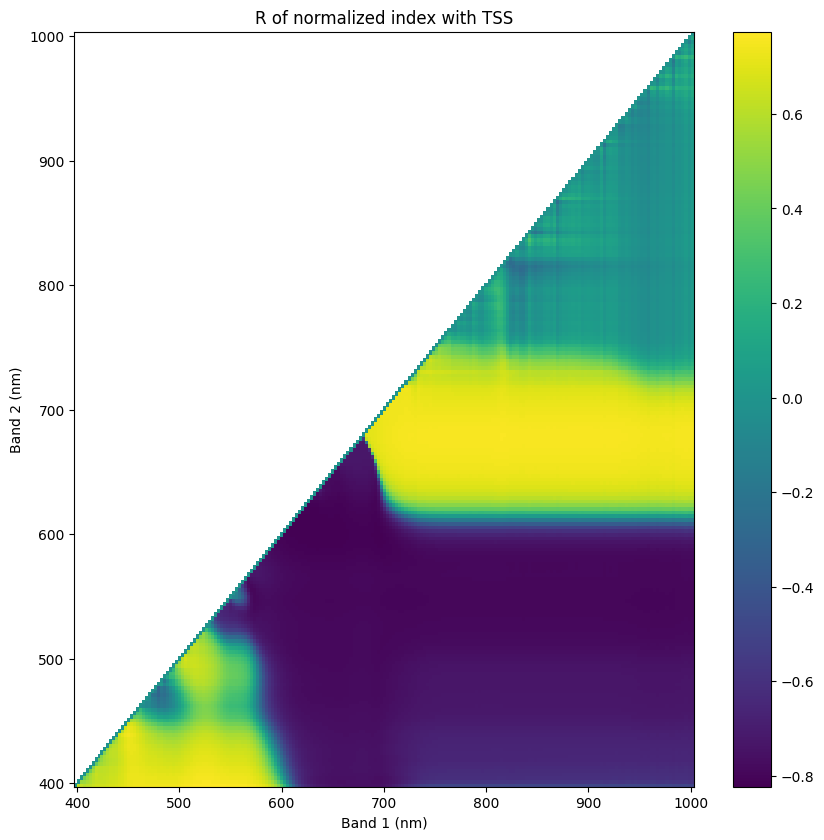

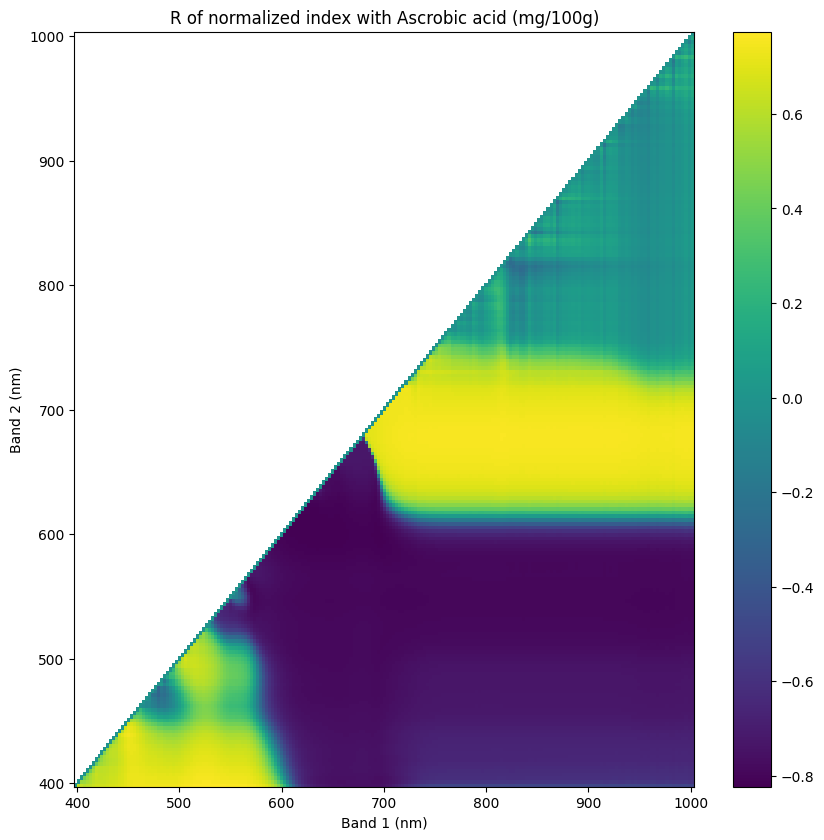

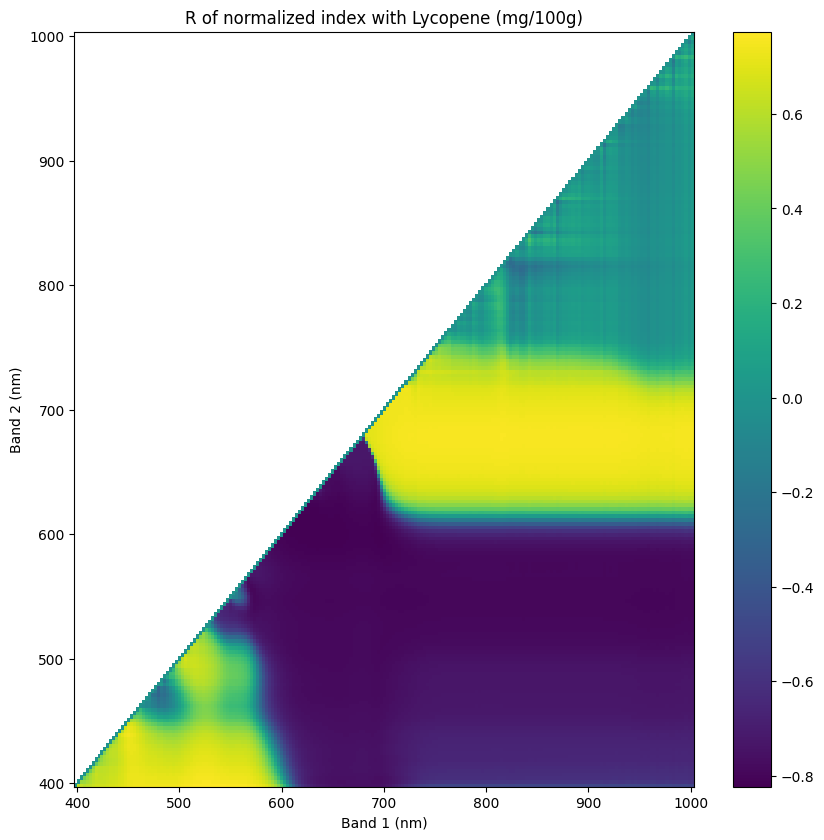

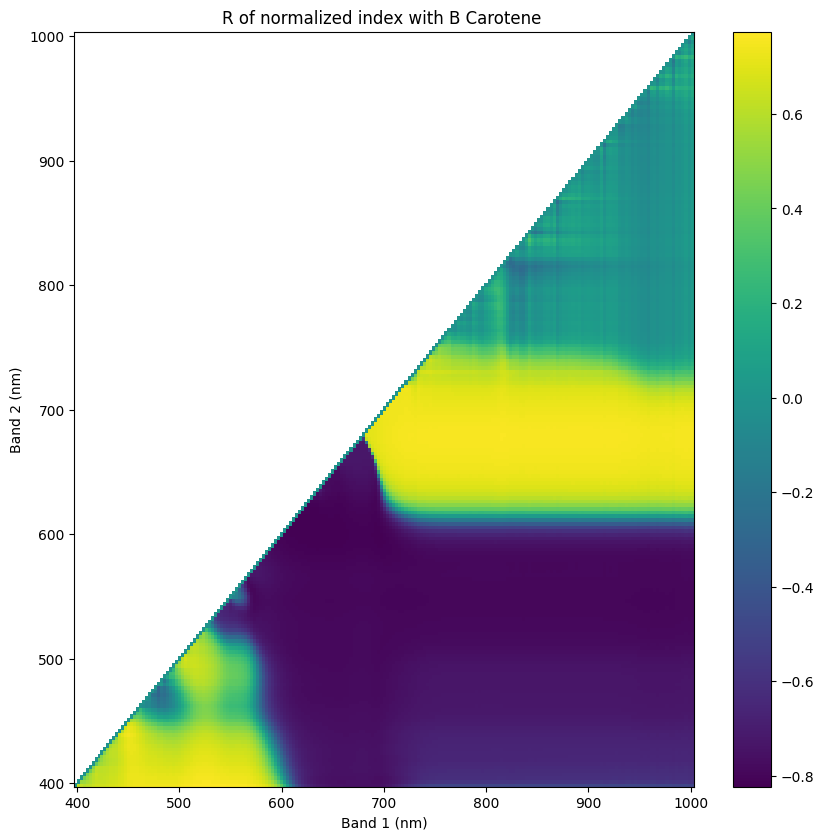

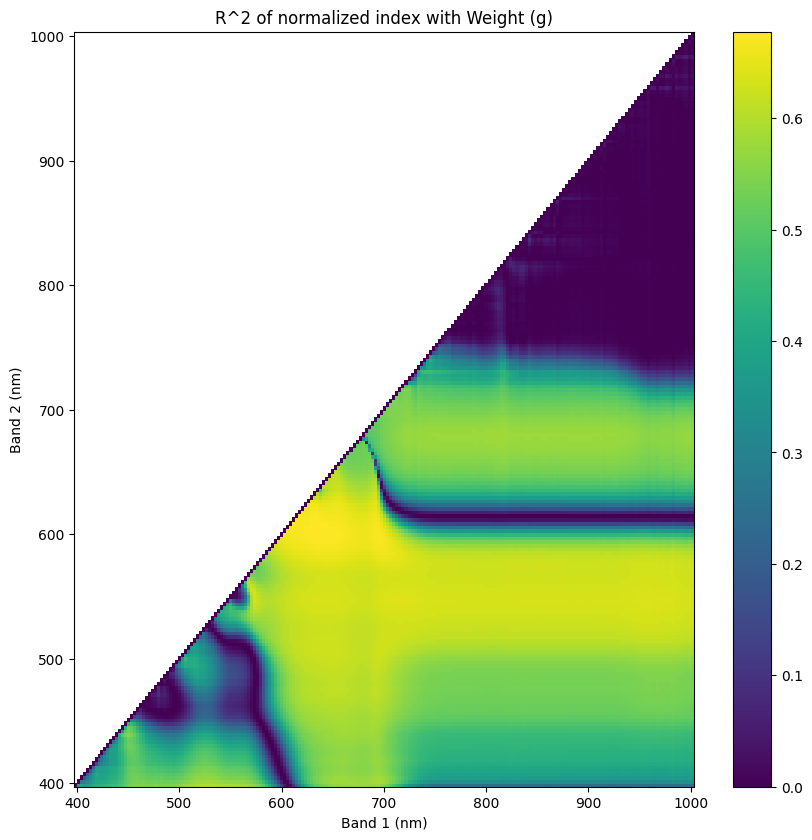

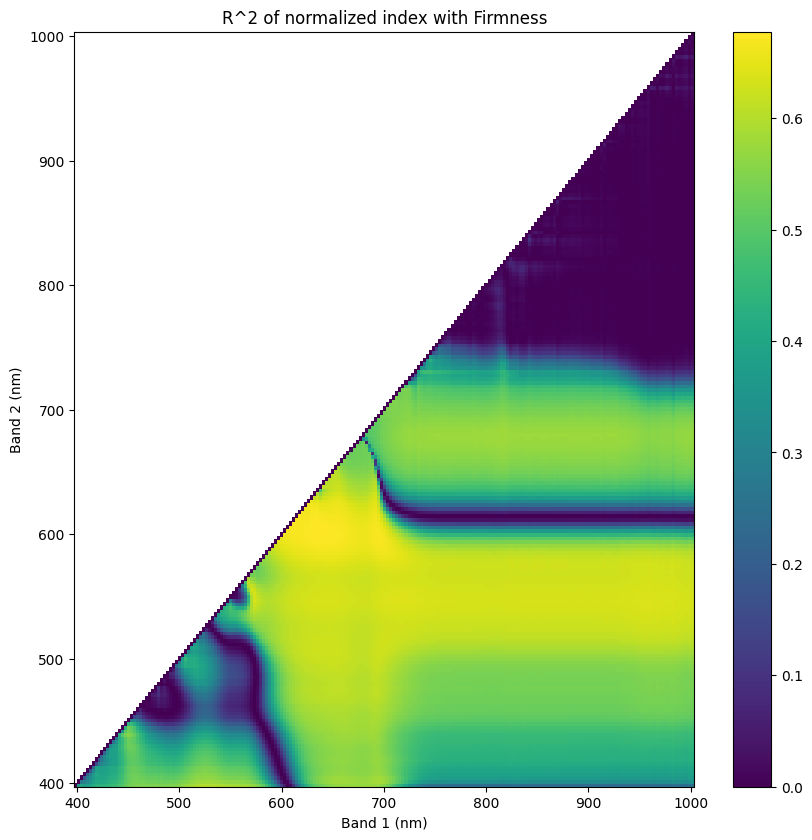

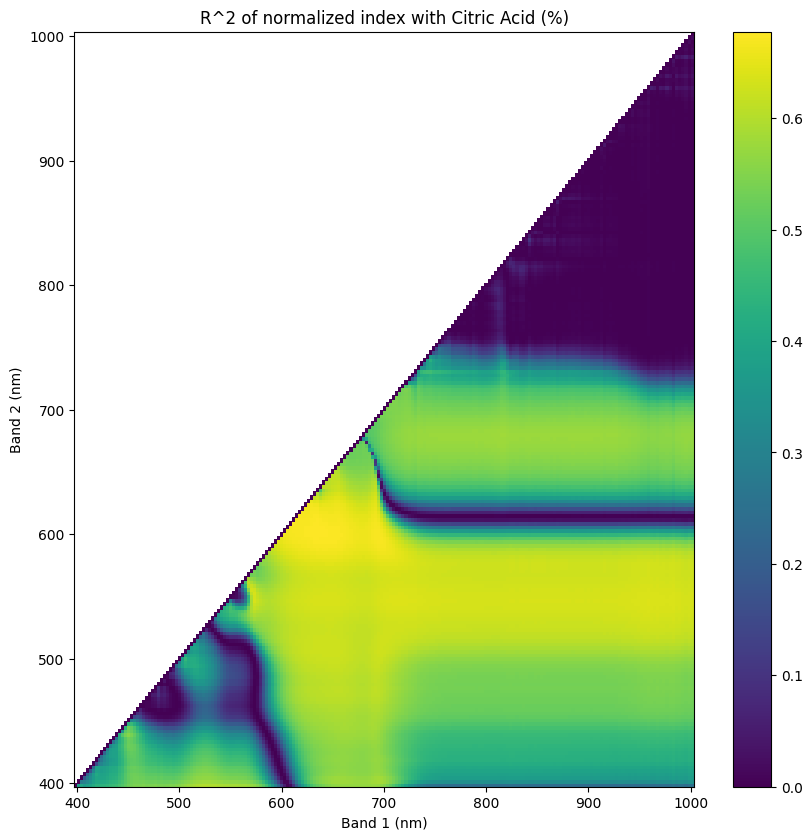

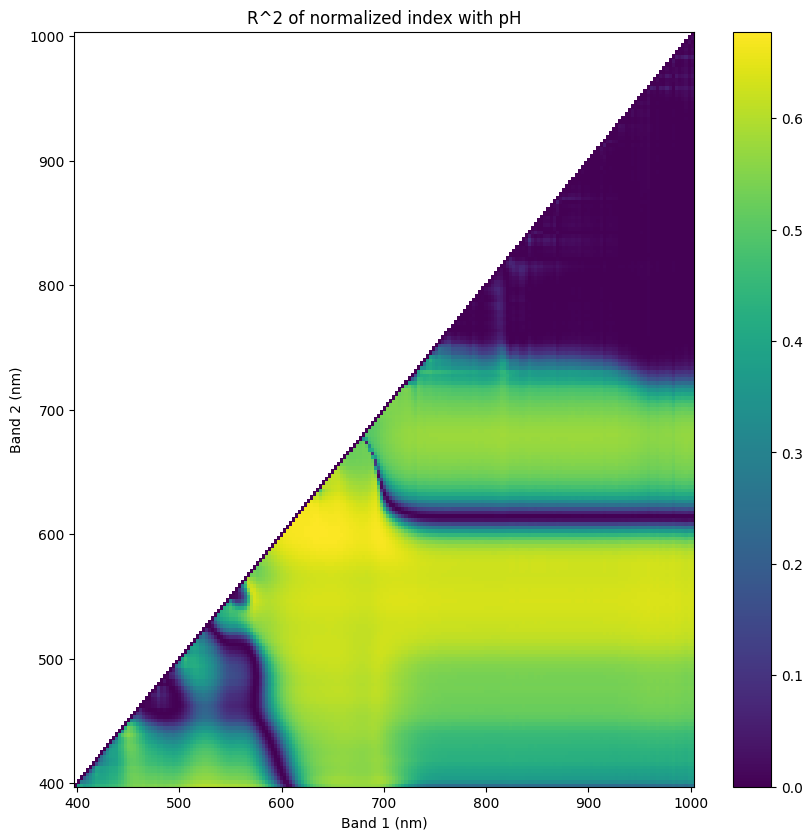

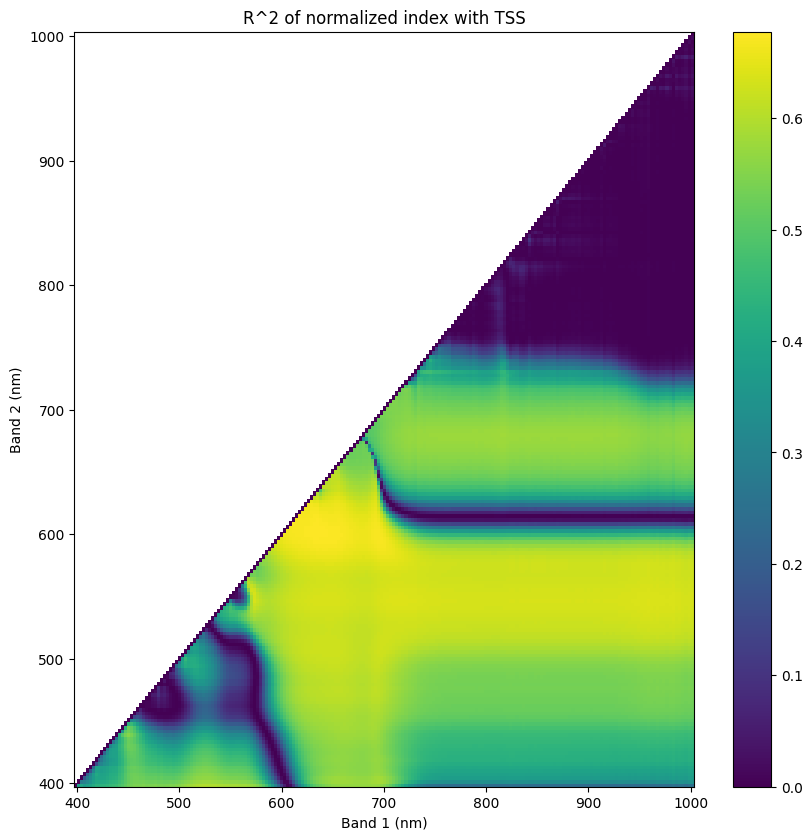

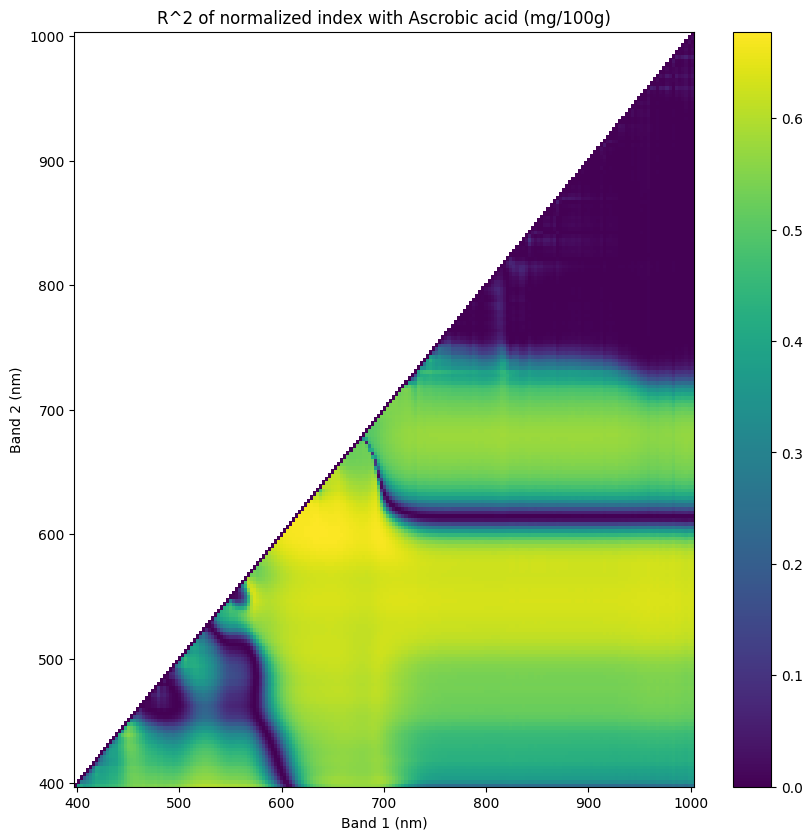

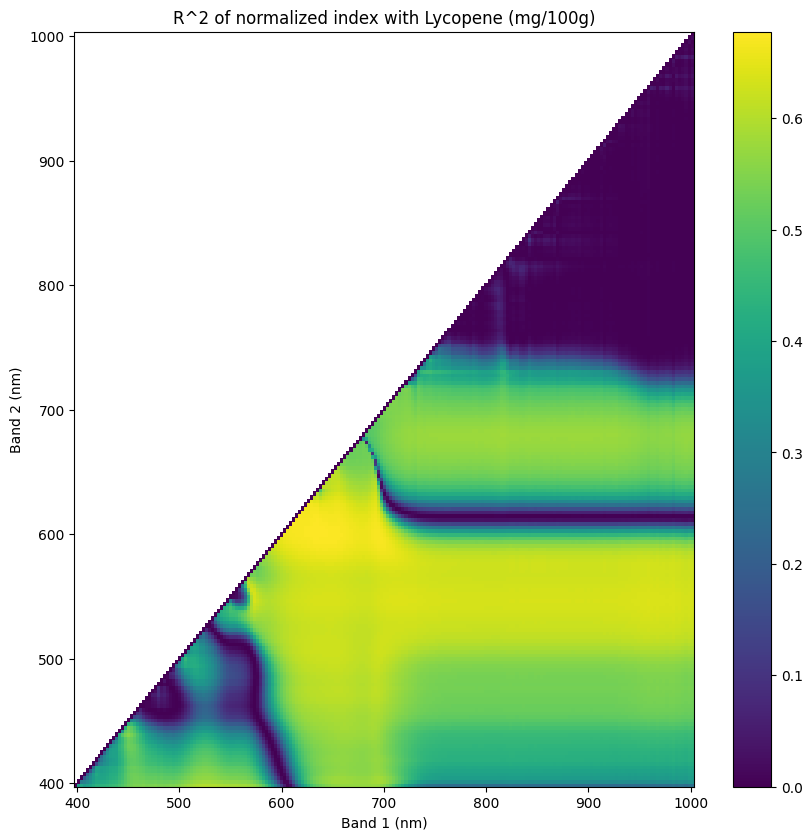

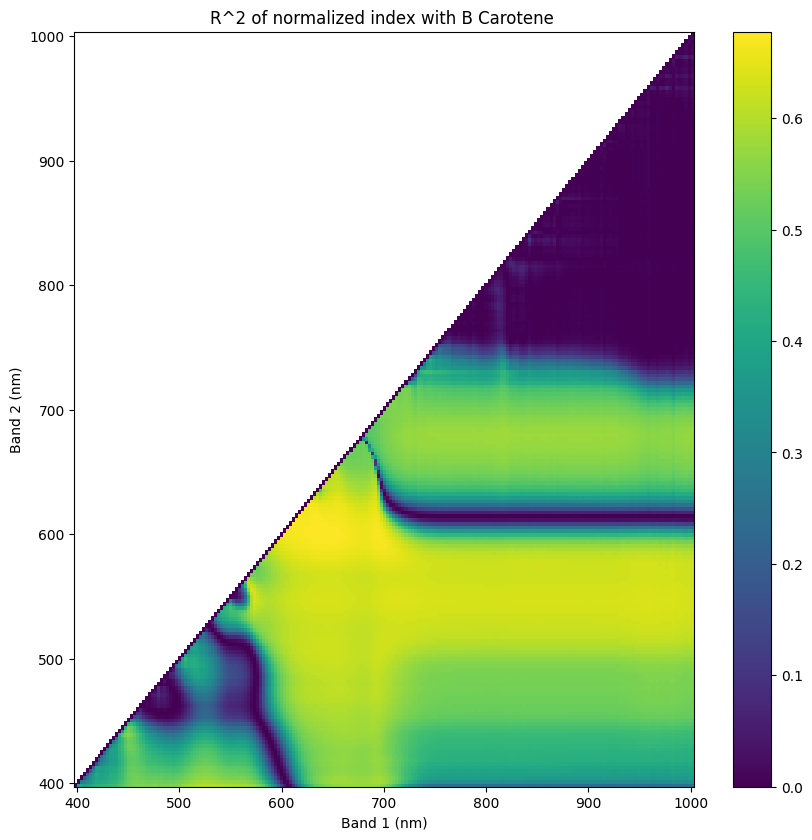

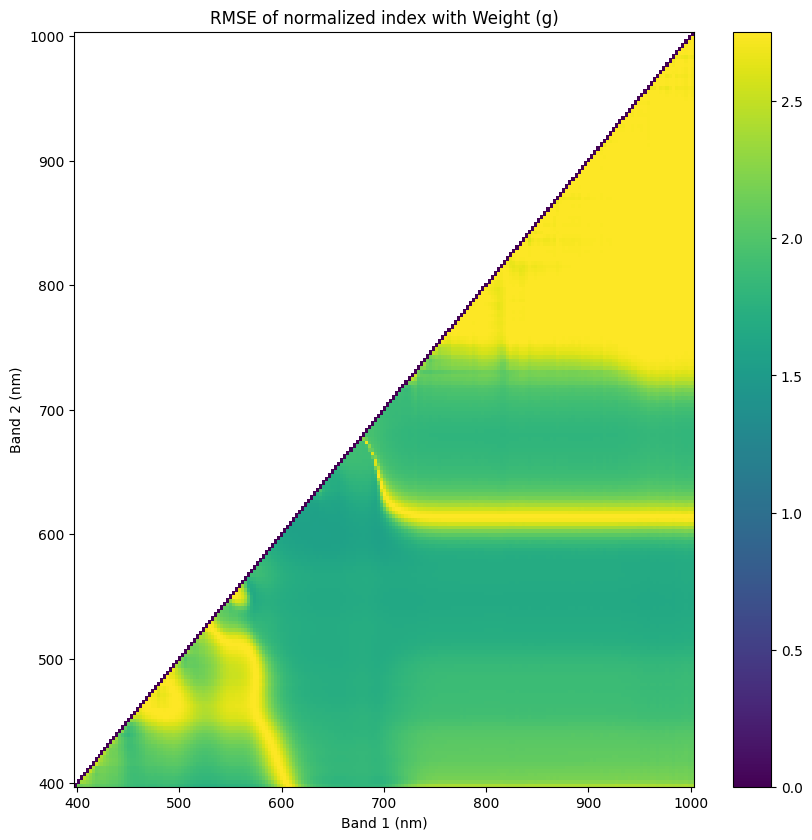

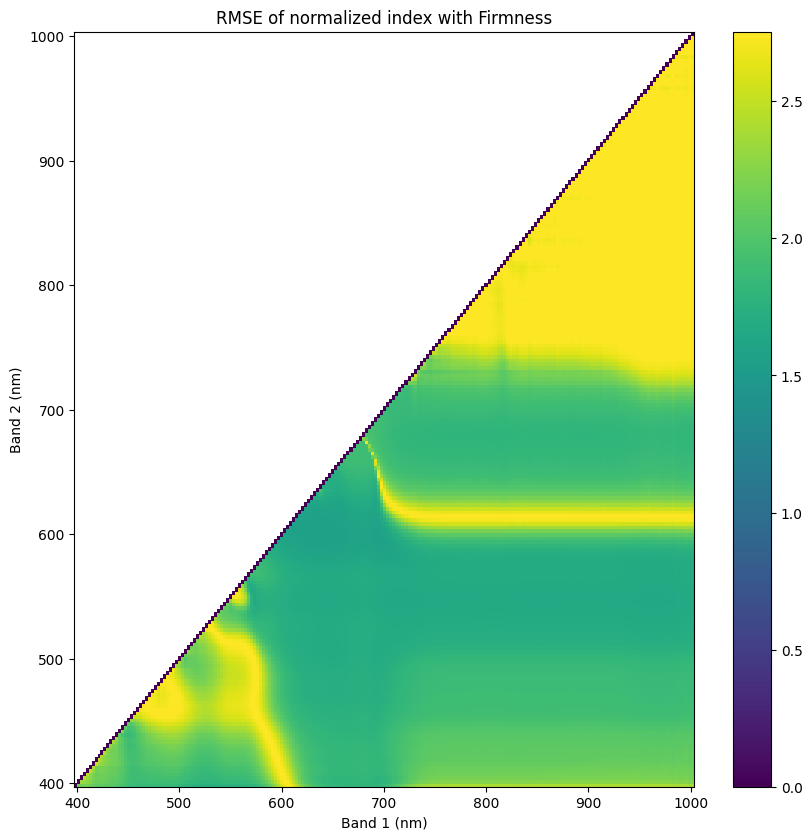

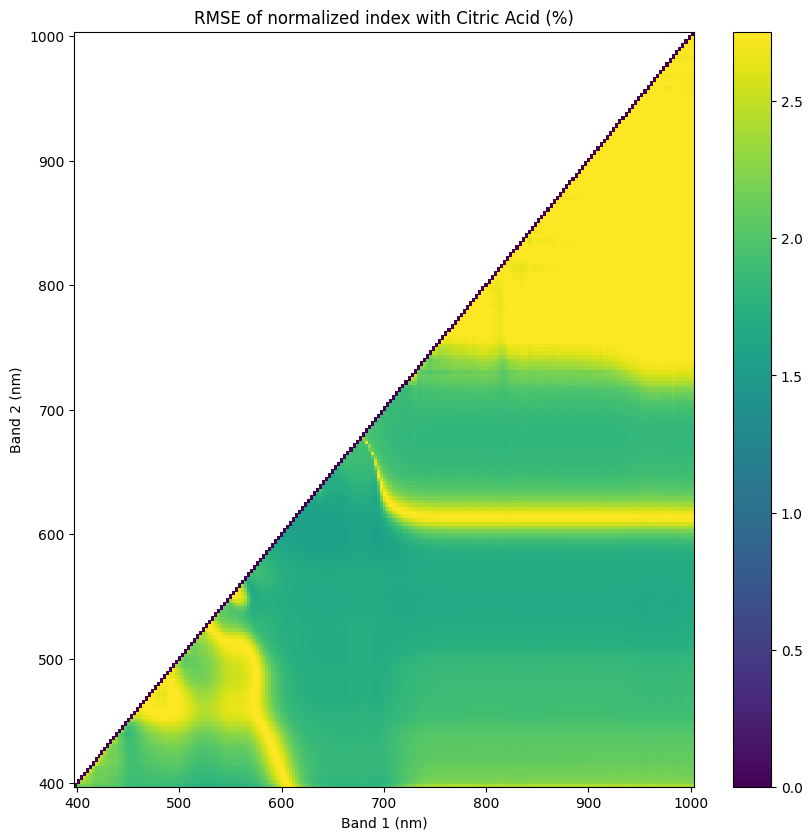

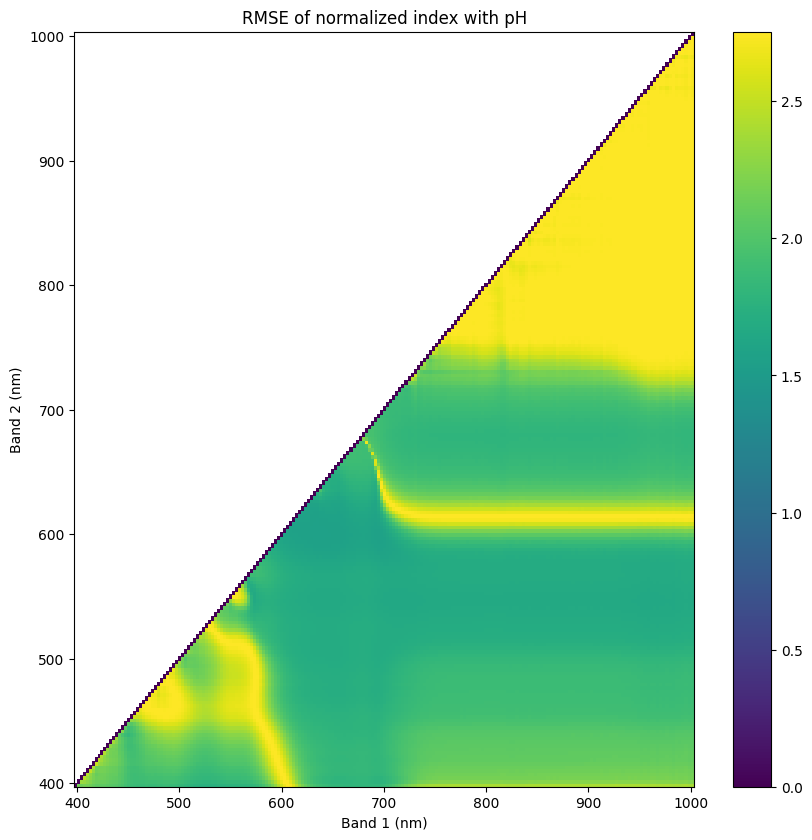

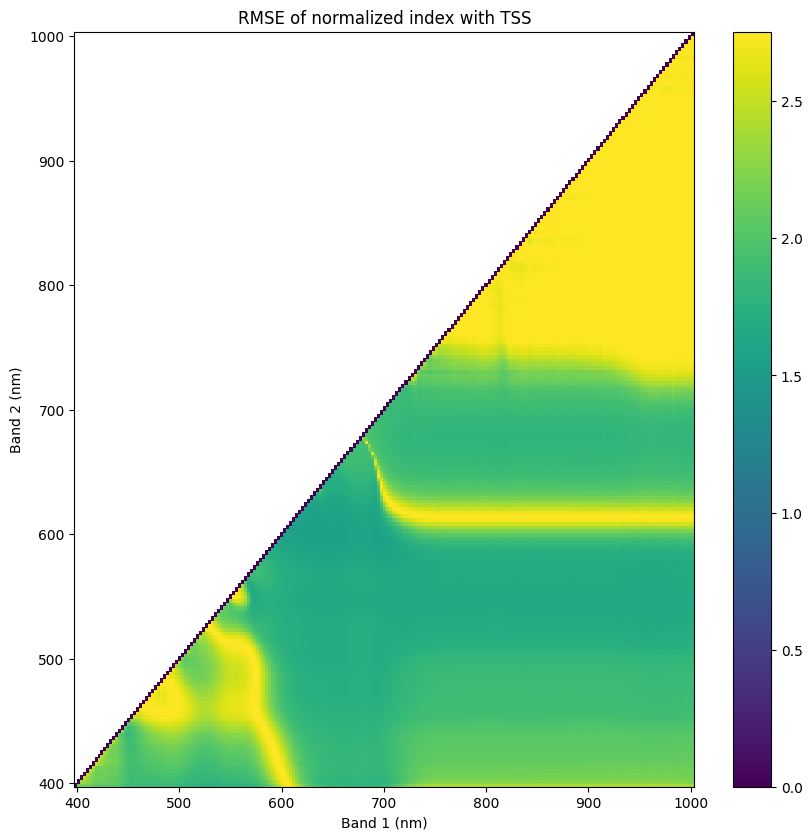

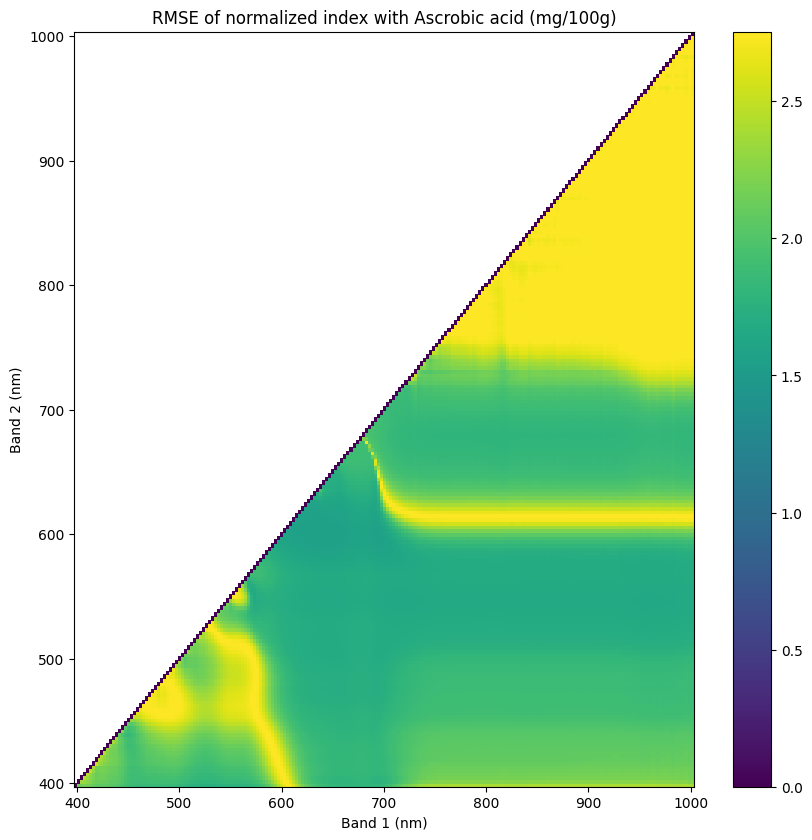

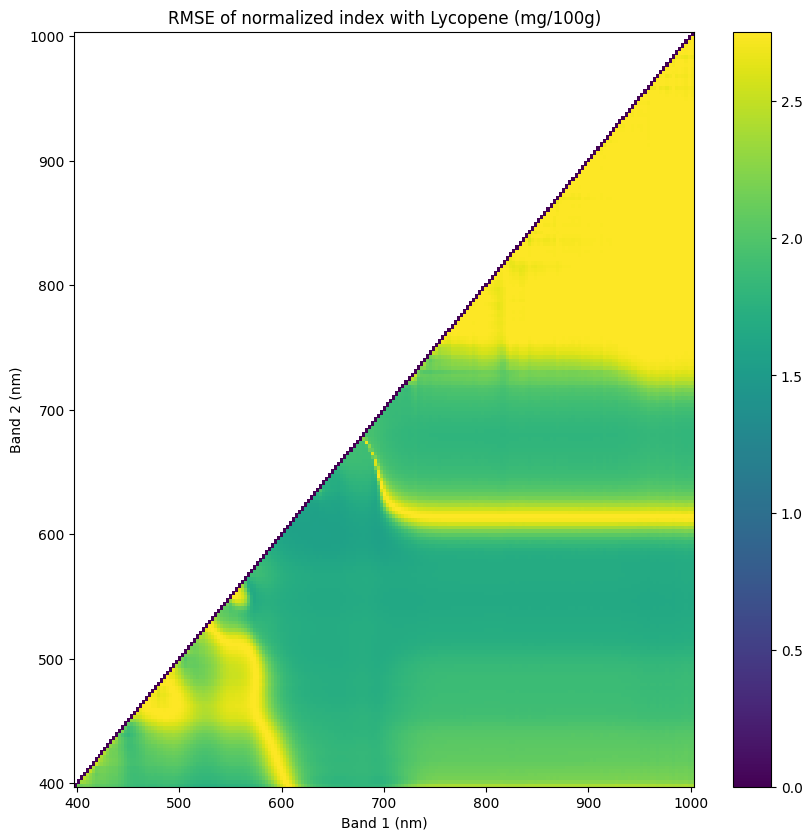

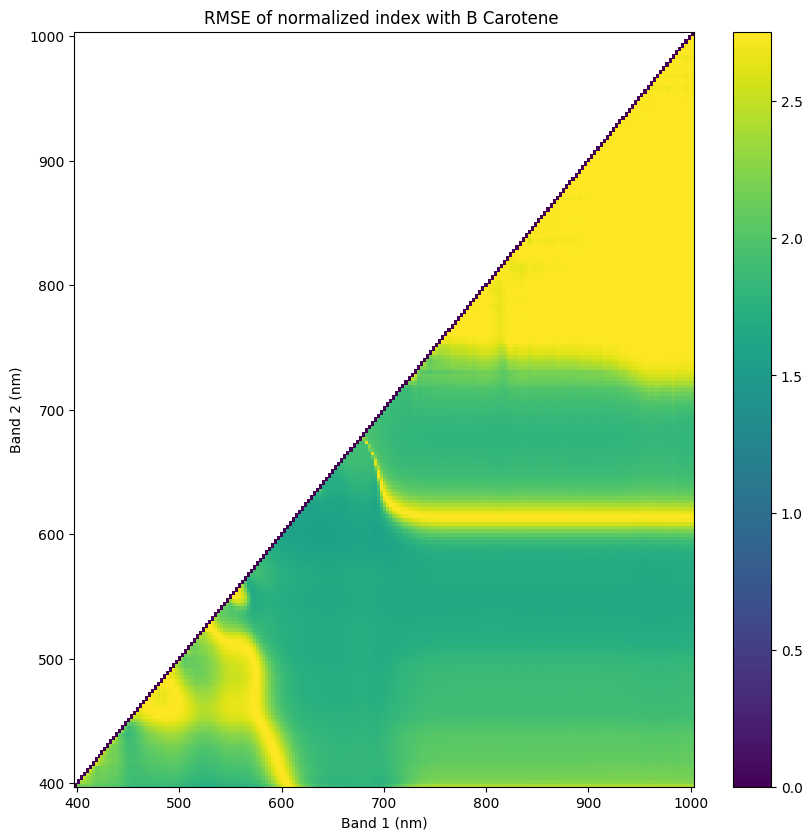

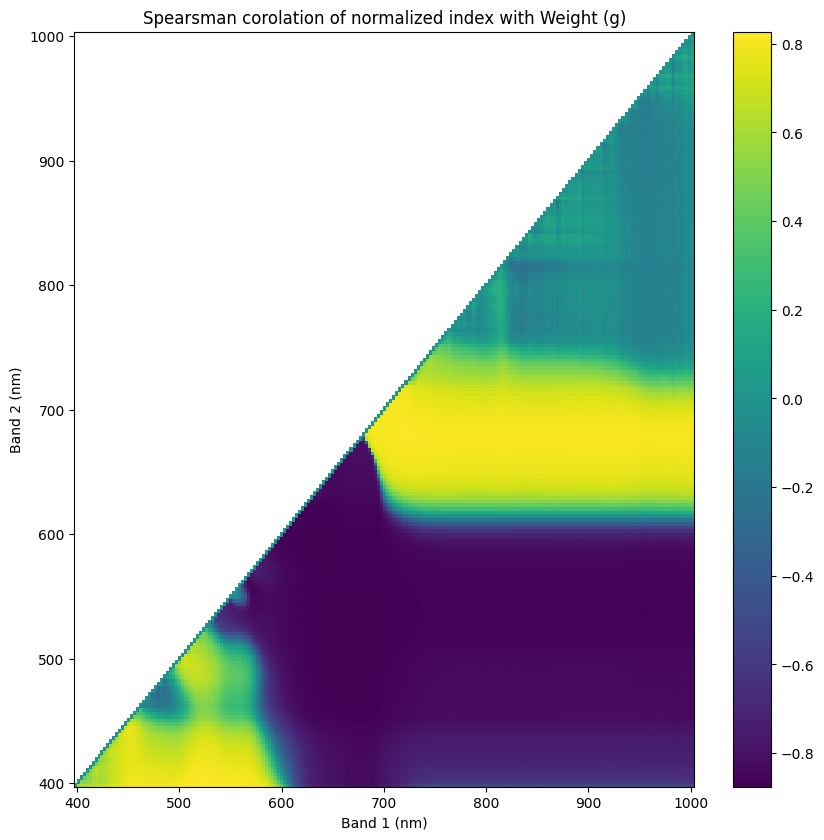

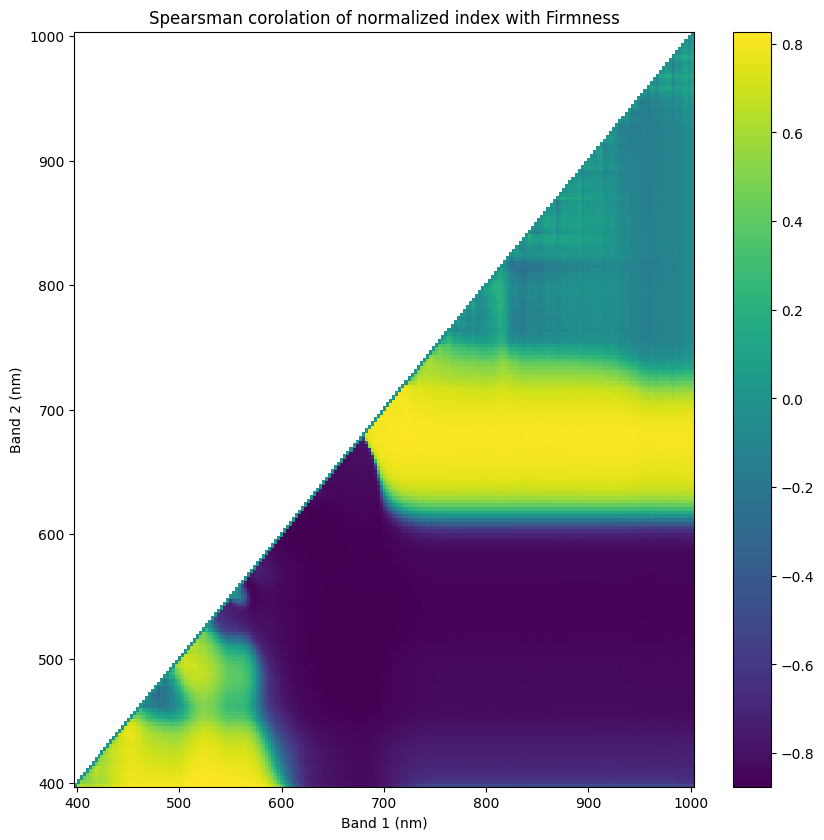

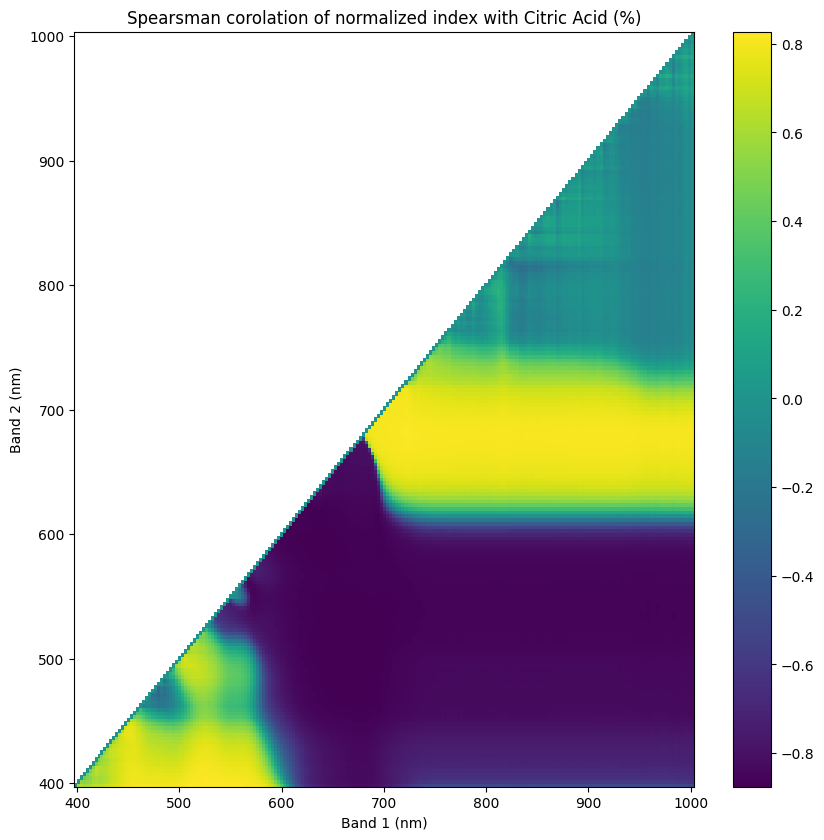

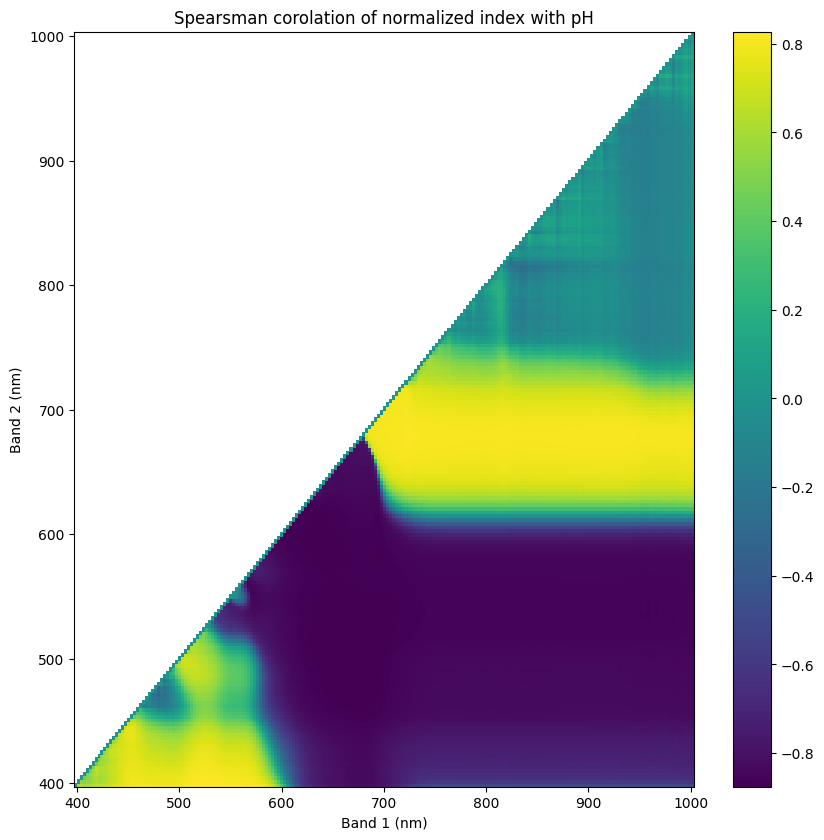

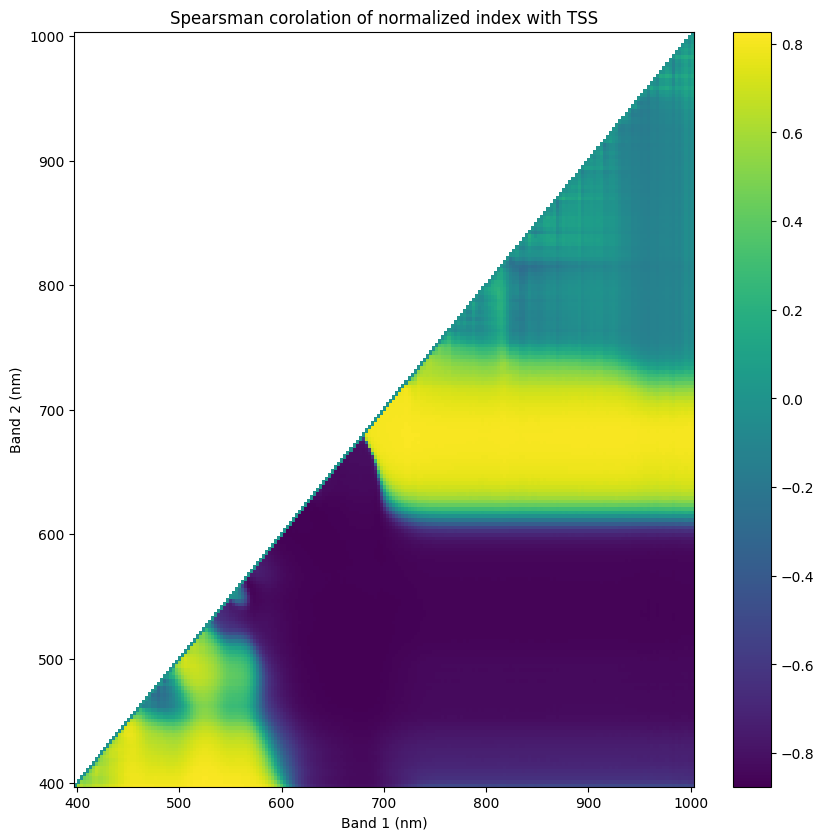

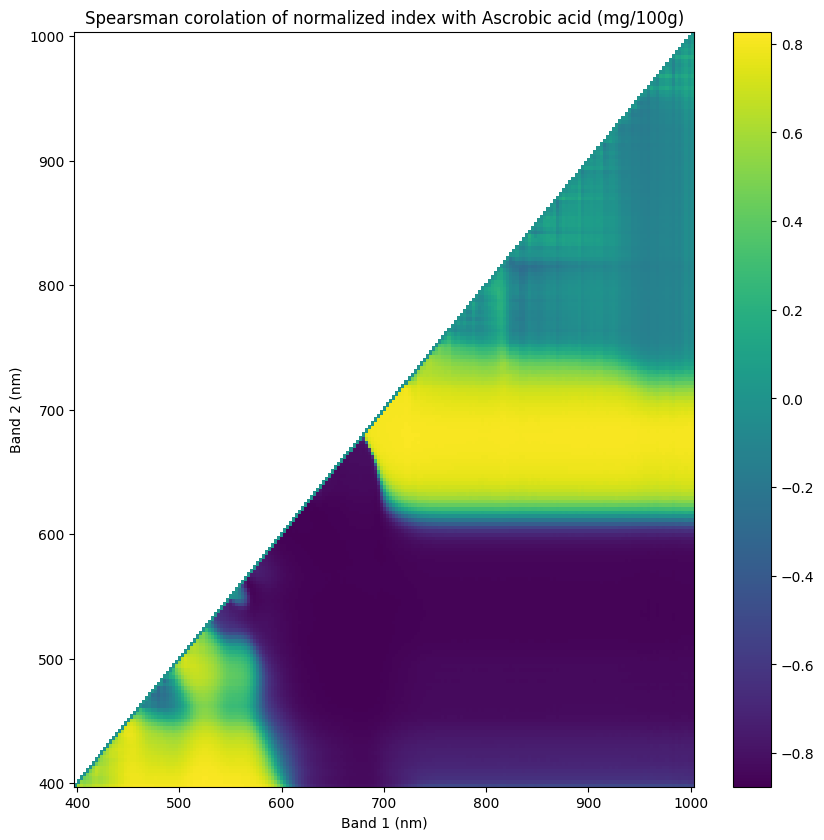

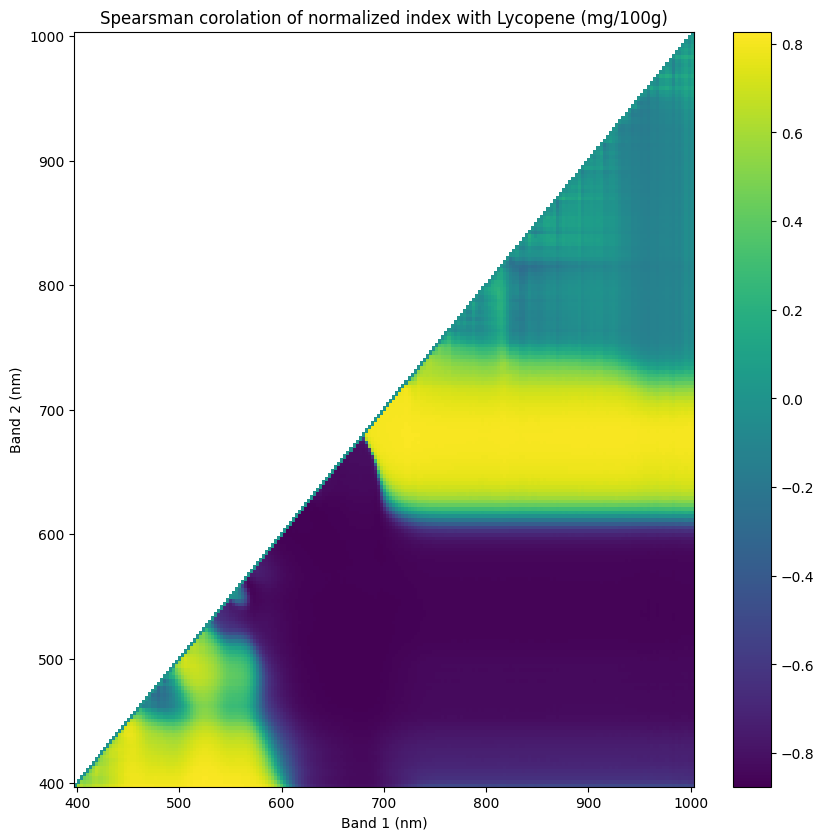

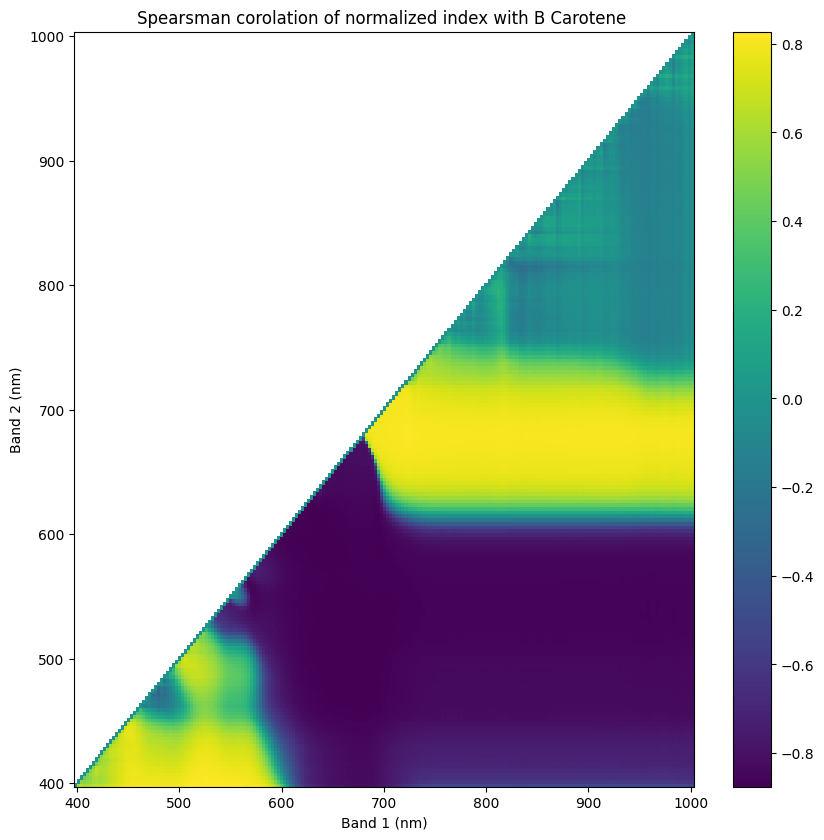

In [53]:

r_2,R,rmse,spear=NI_model(tomato_list)# get the color map dicts

plot_all_color_maps(r_2,R,rmse,spear)

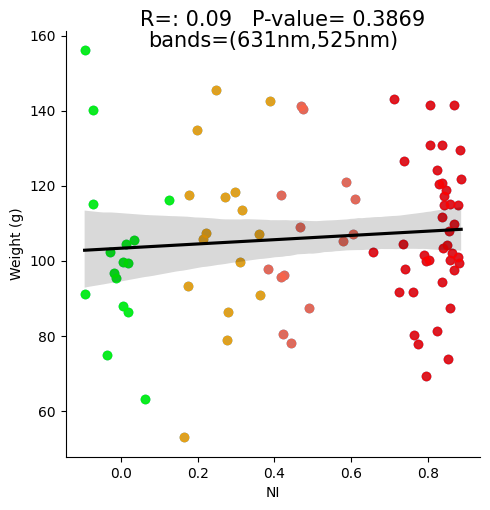

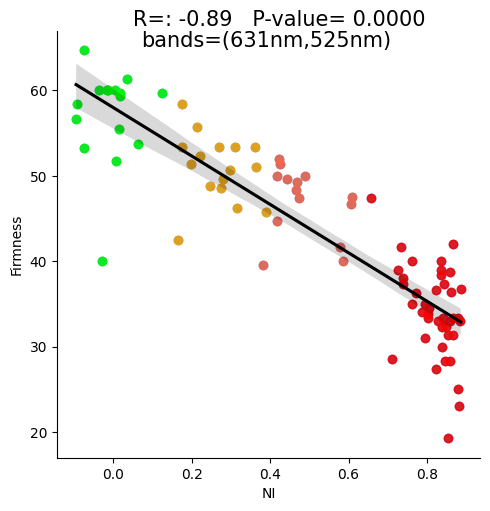

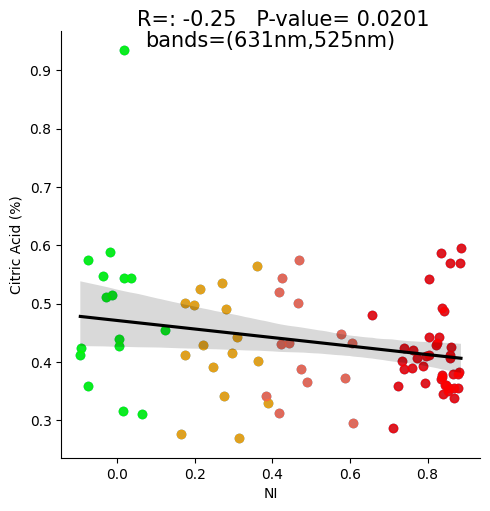

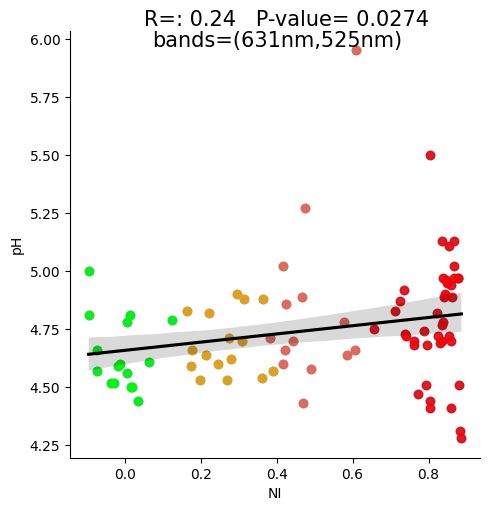

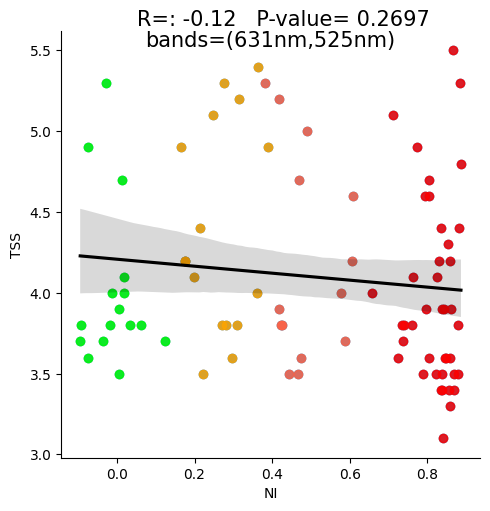

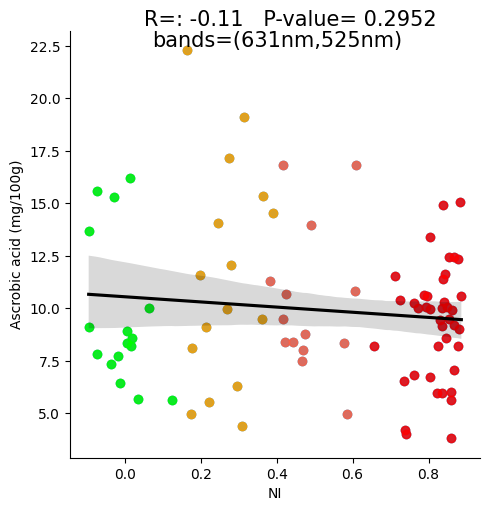

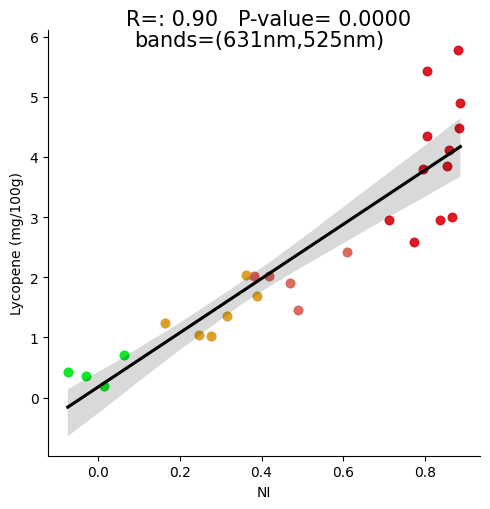

In [20]:

regretionplot(TomatoList([harvest_1,harvest_4]))#,r_2)


#PCA

Text(0.5, 1.0, 'PCA')

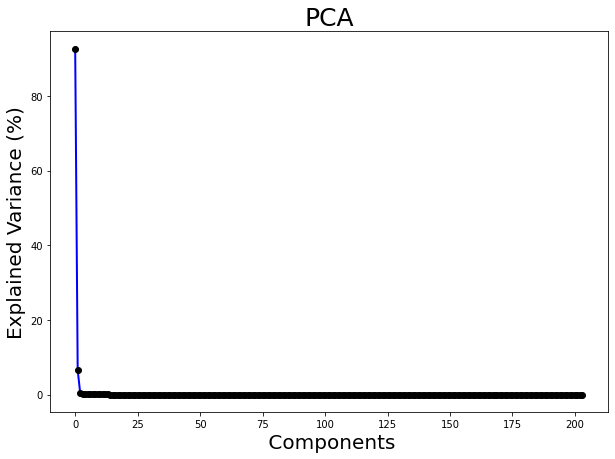

In [64]:
from sklearn.decomposition import PCA
scaler = MinMaxScaler()
df_normalized=scaler.fit_transform(tomato_list.reflectence_df.T)# - tomato_list.reflectence_df.min()) / (tomato_list.reflectence_df.max()-tomato_list.reflectence_df.min())
pca = PCA(n_components=tomato_list.reflectence_df.shape[1])

# Apply the model
pca.fit(df_normalized)
df_pca = pca.transform(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_,
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=tomato_list.reflectence_df.columns)

# Graph
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(pca.explained_variance_ratio_*100, lw =2,color = "blue")
ax.plot(pca.explained_variance_ratio_*100,'o',lw = 8,color = "black")
ax.set_xlabel(" Components",fontsize=20)
ax.set_ylabel("Explained Variance (%)",fontsize=20)
ax.set_title("PCA",fontsize=25)

In [46]:
print(f'using 4 bands captures {pca.explained_variance_ratio_[:3].sum()*100:.1f}% of our data varience') 

using 4 bands captures 99.6% of our data varience


(204, 2)

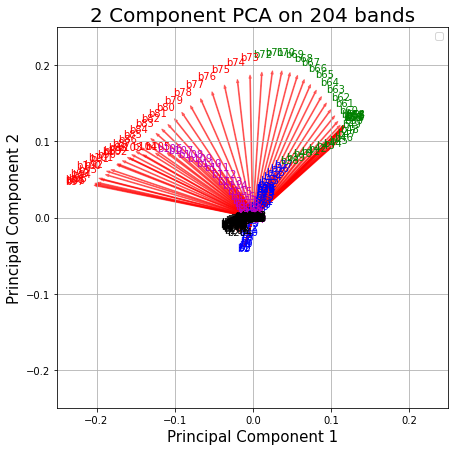

In [66]:
scaler=MinMaxScaler()
data_scaled=pd.DataFrame(df_normalized.T)
pca = PCA(n_components=2)
x_new = pca.fit_transform(data_scaled)
data_scaled['color']=None
data_scaled['label']=None
data_scaled.loc[:36,'color']='b'
data_scaled.loc[37:71,'color']='g'
data_scaled.loc[72:104,'color']='r'
data_scaled.loc[105:137,'color']='m'
data_scaled.loc[138:203,'color']='k'

c=data_scaled['color']
c=c.dropna()
l=['400-500nm','500-600nm','600-700nm','700-800nm','800-1000nm']
data_scaled.loc[:36,'label']=l[0]
data_scaled.loc[37:71,'label']=l[1]
data_scaled.loc[72:104,'label']=l[2]
data_scaled.loc[105:137,'label']=l[3]
data_scaled.loc[138:,'label']=l[4]

def myplot(score,coeff,color,legend,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    # plt.scatter(xs * scalex,ys * scaley, c = 'y')
    for i,c,label in zip(range(n),color,legend):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "b"+str(i+1), color = c, ha = 'center', va = 'center',label=label)

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1) 
ax.set(xlim=[-0.25,0.25],ylim=[-0.25,0.25])

ax.grid()
legend1={'b':'400-500nm','g':'500-600nm','r':'600-700nm','m':'700-800nm','b':'800-1000nm'}
#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]),c,data_scaled['label'][0:204])
ax.legend(legend1)
# ax.title('2 component PCA grid on 204 wavelengths')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA on 204 bands', fontsize = 20)

np.transpose(pca.components_[0:2, :]).shape

In [67]:
from sklearn.feature_selection import VarianceThreshold
scaler=MinMaxScaler()
df_normalized=pd.DataFrame(scaler.fit_transform(tomato_list.reflectence_df.T))
sel = VarianceThreshold(threshold=(0.025))
col=[f'b{i}' for i in  range(1,205)]
df_normalized=pd.DataFrame(data=np.array(tomato_list.reflectence_df),columns=col,)
print(sel.fit_transform(df_normalized).shape)
a=sel.get_feature_names_out()
a

(447, 22)


array(['b50', 'b51', 'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'b89',
       'b90', 'b91', 'b92', 'b93', 'b94', 'b95', 'b96', 'b97', 'b98',
       'b99', 'b100', 'b101', 'b102'], dtype=object)

#rest of old code

###runing a linear regression model on the data

In [ ]:
def RMSE(y, y_pred):
  """MSE loss of one example"""
  return np.sqrt(((y-y_pred)**2)/(2))
np_ref=np.array(df_ref_scaled.T)
np_firrmness=np.array(df_results['firmness AVG'])
fit_all = linear_model.SGDRegressor() # fit over the entire population
fit_all.fit(np_ref,np_firrmness)
total_err = 0
rmse_train_err = 0
rmse_test_err = 0
rmse_all_err = 0
est_err = 0
iternum=30
for m in range(0,iternum):
  # Randomly sample a training dataset and an unseen (test) sample
  X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=280, test_size=40)
  fit_train = linear_model.SGDRegressor() # fit over the test group
  fit_train.fit(X_train,y_train)
  pred_all = fit_all.predict(X_test)
  pred_train = fit_train.predict(X_train)
  pred_test=fit_train.predict(X_test)
  rmse_train_err += RMSE(y_train,pred_train).mean()
  rmse_test_err += RMSE(y_test,pred_test).mean()
  rmse_all_err += RMSE(y_test,pred_all).mean()

rmse_train_err /= iternum #to get average values
rmse_test_err /= iternum
rmse_all_err /= iternum

print('RMSE train error : ' + '{:.2f}'.format(rmse_train_err))
print('RMSE test error : ' + '{:.2f}'.format(rmse_test_err))
print('RMSE all samples error : ' + '{:.2f}'.format(rmse_all_err))




### Running random forest tree model on the data

In [ ]:

def RMSE(y, y_pred):
  """MSE loss of one example"""
  return np.sqrt(((y-y_pred)**2)/(2))

def add_ref_to_res(ref,res):
  bwr={}#bands with result conected
  length=ref.shape[0]
  new_index=np.arange(0,length)
  ref=ref.set_index(new_index)
  res=res.set_index(new_index)
  for i in res.columns:
    if i=='ID':
      continue
    bwr[i]=pd.concat([ref,res[i]],axis=1)
  return bwr
scaler=MinMaxScaler()
roma_ref_scaled=pd.DataFrame(scaler.fit_transform(roma_ref))
random_forest = RandomForestRegressor()
roma_ref_res=add_ref_to_res(roma_ref_scaled,roma_results)
for i in roma_results.columns:
  # i='% citric acid'
  if i== 'B carotene 'or i=='lycopene':
    continue
  col=roma_ref_res[i].columns
  r=roma_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  fit_all = RandomForestRegressor() # fit over the entire population
  fit_all.fit(np_ref,np_firrmness)
  total_err = 0
  rmse_train_err = 0
  rmse_test_err = 0
  rmse_all_err = 0
  est_err = 0
  iternum=30
  for m in range(0,iternum):
    # Randomly sample a training dataset and an unseen (test) sample
    X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=268, test_size=40)
    fit_train = RandomForestRegressor() # fit over the test group
    fit_train.fit(X_train,y_train)
    pred_all = fit_all.predict(X_test)
    pred_train = fit_train.predict(X_train)
    pred_test=fit_train.predict(X_test)
    rmse_train_err += RMSE(y_train,pred_train).mean()
    rmse_test_err += RMSE(y_test,pred_test).mean()
    rmse_all_err += RMSE(y_test,pred_all).mean()

  rmse_train_err /= iternum #to get average values
  rmse_test_err /= iternum
  rmse_all_err /= iternum
  print(i)
  print('RMSE train error : ' + '{:.2f}'.format(rmse_train_err))
  print('RMSE test error : ' + '{:.2f}'.format(rmse_test_err))
  print('RMSE all samples error : ' + '{:.2f}'.format(rmse_all_err))
  print('R2 train error : ' + '{:.2f}'.format(r2_score(y_train,pred_train)))
  print('R2 test error : ' + '{:.2f}'.format(r2_score(y_test, pred_test)))
  print('R2 all samples error : ' + '{:.2f}'.format(r2_score(y_test,pred_all)))
  plt.plot(y_test, pred_test,'o')
  plt.show()

In [ ]:
 scaler=MinMaxScaler()
soli_ref_scaled=pd.DataFrame(scaler.fit_transform(soli_ref))
random_forest = RandomForestRegressor()
soli_ref_res=add_ref_to_res(soli_ref_scaled,soli_results)
for i in soli_results.columns[2:]:
  i= '% citric acid'
  if i== 'B carotene ':
    continue
  col=soli_ref_res[i].columns
  r=soli_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  fit_all = RandomForestRegressor() # fit over the entire population
  fit_all.fit(np_ref,np_firrmness)
  total_err = 0
  rmse_train_err = 0
  rmse_test_err = 0
  rmse_all_err = 0
  est_err = 0
  iternum=30
  for m in range(0,iternum):
    # Randomly sample a training dataset and an unseen (test) sample
    X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=30, test_size=10)
    fit_train = RandomForestRegressor() # fit over the test group
    fit_train.fit(X_train,y_train)
    pred_all = fit_all.predict(X_test)
    pred_train = fit_train.predict(X_train)
    pred_test=fit_train.predict(X_test)
    rmse_train_err += RMSE(y_train,pred_train).mean()
    rmse_test_err += RMSE(y_test,pred_test).mean()
    rmse_all_err += RMSE(y_test,pred_all).mean()

  rmse_train_err /= iternum #to get average values
  rmse_test_err /= iternum
  rmse_all_err /= iternum
  print(i)
  print('RMSE train error : ' + '{:.2f}'.format(rmse_train_err))
  print('RMSE test error : ' + '{:.2f}'.format(rmse_test_err))
  print('RMSE all samples error : ' + '{:.2f}'.format(rmse_all_err))
  print('R2 train error : ' + '{:.2f}'.format(r2_score(y_train,pred_train)))
  print('R2 test error : ' + '{:.2f}'.format(r2_score(y_test, pred_test)))
  print('R2 all samples error : ' + '{:.2f}'.format(r2_score(y_test,pred_all)))
  plt.plot(y_test, pred_test,'o')
  plt.show()

In [ ]:
scaler=MinMaxScaler()
united_ref_scaled=pd.DataFrame(scaler.fit_transform(united_ref))
random_forest = RandomForestRegressor()
united_ref_res=add_ref_to_res(united_ref_scaled,united_results)
for i in soli_results.columns[1:]:
  
  if i== 'B carotene 'or i =='lycopene':
    continue
  col=united_ref_res[i].columns
  r=united_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  fit_all = RandomForestRegressor() # fit over the entire population
  fit_all.fit(np_ref,np_firrmness)
  total_err = 0
  rmse_train_err = 0
  rmse_test_err = 0
  rmse_all_err = 0
  est_err = 0
  iternum=30
  for m in range(0,iternum):
    # Randomly sample a training dataset and an unseen (test) sample
    X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=280, test_size=40)
    fit_train = RandomForestRegressor() # fit over the test group
    fit_train.fit(X_train,y_train)
    pred_all = fit_all.predict(X_test)
    pred_train = fit_train.predict(X_train)
    pred_test=fit_train.predict(X_test)
    rmse_train_err += RMSE(y_train,pred_train).mean()
    rmse_test_err += RMSE(y_test,pred_test).mean()
    rmse_all_err += RMSE(y_test,pred_all).mean()

  rmse_train_err /= iternum #to get average values
  rmse_test_err /= iternum
  rmse_all_err /= iternum
  print(i)
  print('RMSE train error : ' + '{:.2f}'.format(rmse_train_err))
  print('RMSE test error : ' + '{:.2f}'.format(rmse_test_err))
  print('RMSE all samples error : ' + '{:.2f}'.format(rmse_all_err))
  print('R2 train error : ' + '{:.2f}'.format(r2_score(y_train,pred_train)))
  print('R2 test error : ' + '{:.2f}'.format(r2_score(y_test, pred_test)))
  print('R2 all samples error : ' + '{:.2f}'.format(r2_score(y_test,pred_all)))
  plt.plot(y_test, pred_test,'o')
  plt.show()

In [ ]:
class Tomatoes:
  def __init__(self):
    root_data_path='/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/SPECTRAL_DATA/Reflectence_ID1_320.csv'
    root_result_path='/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/VOLCANI_CENTER/CHEMICAL _RESULTS_ROMA_AS_200_13_10_2021_ID_1_320.csv'
    df_ref=  pd.read_csv(root_data_path) 
    col=df_ref.columns
    scaler = MinMaxScaler()
    df_ref=df_ref.drop([col[0]], axis=1)
    df_ref_scaled=np.array(scaler.fit_transform(df_ref))
    df_results=  pd.read_csv(root_result_path)  
    df_results=df_results.drop(['ID'],axis=1)
    scaler = MinMaxScaler()
    x=np.array(df_ref_scaled).T
    # x = df_ref.values
    y=df_results['firmness AVG'].values
    self.x=torch.tensor(x,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.float32)
    

  def __getitem__(self,index): 
    ref = self.x[index, :]
    result = self.y[index]
    return ref, result
       
  def __len__(self): 
    return len(self.y)

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")


In [ ]:
T=Tomatoes()
index=random.randint(0,T.__len__())
tomato, label=T.__getitem__(index)
plt.plot(range(0,204),tomato)
plt.title(f'Tomato {index}')
plt.ylabel('Reflectence')
plt.xlabel('channel')
print(f'firmness is {label} (N)')

In [ ]:
batch_size = 30

In [ ]:
train_validation_split = 0.70 
validation_test_split = 0.85 
shuffle_dataset = True
random_seed = None # Make this None to have a different shuffling each run

# Creating random data indices for training, validation and testing splits:
dataset_size =T.__len__()
indices = list(range(dataset_size))
split_val = int(np.floor(train_validation_split * dataset_size))
split_test = int(np.floor(validation_test_split * dataset_size))
if shuffle_dataset:
  if random_seed is not None:
    np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:split_val], indices[split_val:split_test], indices[split_test:]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(T, batch_size=batch_size,
                                          sampler=train_sampler, pin_memory=True,drop_last=True)
validation_loader = torch.utils.data.DataLoader(T, batch_size=batch_size,
                                          sampler=valid_sampler, pin_memory=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(T, batch_size=batch_size, 
                                          sampler=test_sampler, pin_memory=True,drop_last=True)


In [ ]:
class TomatoNet(nn.Module):
   def __init__(self):
        super(TomatoNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(204,102),
            nn.ReLU(),
            nn.Linear(102, 51),
            nn.ReLU(),
            nn.Linear(51, 1),
        )

   def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits  

In [ ]:
model = TomatoNet().to(device)
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

In [ ]:

def plot_acc_loss(model_history,title):
  plt.figure(figsize=(15, 5))
  #model_history= [train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history]
  # plt.subplot(1,2,1)
  plt.plot(model_history[0],'b', label='Train')
  plt.plot(model_history[1],'r', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('CrossEntropy loss')
  plt.legend()
  best_val_loss = np.min(model_history[1])
  best_val_loss_i = np.argmin(model_history[1])
  plt.scatter(best_val_loss_i, best_val_loss, color='green', s=150, marker='X', zorder=3)
  plt.text(best_val_loss_i, best_val_loss, '\nBest validation\nloss: {:.3f}'.format(best_val_loss), va='top')
  # plt.subplot(1,2,2)
  # plt.plot(model_history[1],'b', label='Train')
  # plt.plot(model_history[3],'r', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.legend()
  plt.title(title)
  plt.show()


In [ ]:
pip install skorch

In [ ]:
from skorch import NeuralNetRegressor
from torch import optim
from sklearn.metrics import mean_squared_error
scaler=MinMaxScaler()
united_ref_scaled=pd.DataFrame(scaler.fit_transform(united_ref))
random_forest = RandomForestRegressor()
united_ref_res=add_ref_to_res(united_ref_scaled,united_results)
for i in soli_results.columns[1:]:
  i='pH'
  if i== 'B carotene 'or i =='lycopene':
    continue
  col=united_ref_res[i].columns
  r=united_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=300, test_size=50)
  learning_rate=0.001
  y_train = y_train.reshape(-1, 1)
  y_train=y_train.astype(np.float32)
  X_train=X_train.astype(np.float32)
  X_test=X_test.astype(np.float32)
  skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=300,lr=learning_rate,verbose=0, batch_size=16)
  skorch_regressor.fit(X_train,y_train)
  Y_preds = skorch_regressor.predict(X_test)

  print(i)
  print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
  print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

  print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
  print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))


In [ ]:
from skorch import NeuralNetRegressor
from torch import optim
from sklearn.metrics import mean_squared_error
scaler=MinMaxScaler()
roma_ref_scaled=pd.DataFrame(scaler.fit_transform(roma_ref))
random_forest = RandomForestRegressor()
roma_ref_res=add_ref_to_res(roma_ref_scaled,roma_results)
for i in soli_results.columns[1:]:
  i ='lycopene'
  if i== 'B carotene ':
    continue
  col=united_ref_res[i].columns
  r=roma_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=268, test_size=40)
  learning_rate=0.001
  y_train = y_train.reshape(-1, 1)
  y_train=y_train.astype(np.float32)
  X_train=X_train.astype(np.float32)
  X_test=X_test.astype(np.float32)
  skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=300,lr=learning_rate,verbose=0, batch_size=16)
  skorch_regressor.fit(X_train,y_train)
  Y_preds = skorch_regressor.predict(X_test)

  print(i)
  # print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
  print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

  # print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
  print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))


In [ ]:
from skorch import NeuralNetRegressor
from torch import optim
from sklearn.metrics import mean_squared_error
scaler=MinMaxScaler()
soli_ref_scaled=pd.DataFrame(scaler.fit_transform(soli_ref))
random_forest = RandomForestRegressor()
soli_ref_res=add_ref_to_res(soli_ref_scaled,soli_results)
for i in soli_results.columns[1:]:
  
  if i== 'B carotene ':
    continue
  col=soli_ref_res[i].columns
  r=soli_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=25, test_size=15)
  learning_rate=0.001
  y_train = y_train.reshape(-1, 1)
  y_train=y_train.astype(np.float32)
  X_train=X_train.astype(np.float32)
  X_test=X_test.astype(np.float32)
  skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=300,lr=learning_rate,verbose=0, batch_size=16)
  skorch_regressor.fit(X_train,y_train)
  Y_preds = skorch_regressor.predict(X_test)

  print(i)
  # print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
  print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

  # print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
  print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))


In [ ]:
Y_preds = skorch_regressor.predict(X_test)
from sklearn.metrics import mean_squared_error

print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))

In [ ]:
model_history=skorch_regressor.history[:, ("train_loss", "valid_loss")]
model_history_train=[np.sqrt(i[0]) for i in model_history]
model_history_val=[np.sqrt(i[1]) for i in model_history]
model_history=[model_history_train,model_history_val]
title=f'NN epochs='#{epoch_num}, batch size={batch_size}, lr={learning_rate}, hidden lyers=3, optimizer= Adam'
plot_acc_loss(model_history,title)


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    "lr": [0.01, 0.02,0.5,0.005],
    "max_epochs": [100, 250, 500],
}

grid = GridSearchCV(skorch_regressor, params)

grid.fit(X_train, y_train)

In [ ]:
print("Best Score  : {}".format(grid.best_score_))
print("Best Params : {}".format(grid.best_params_))

In [ ]:
learning_rate=0.02
skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=500,lr=learning_rate,verbose=0, batch_size=16)
skorch_regressor.fit(X_train,y_train)
params = {
    "optimizer__weight_decay": [0, 0.1,0.2,0.3],
    "optimizer": [optim.Adam,optim.SGD],
    "batch_size":[8,16,32]

}

grid = GridSearchCV(skorch_regressor, params)

grid.fit(X_train, y_train)

In [ ]:
print("Best Score  : {}".format(grid.best_score_))
print("Best Params : {}".format(grid.best_params_))

In [ ]:
learning_rate=0.002
skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=500,lr=learning_rate,verbose=0, batch_size=8)
skorch_regressor.fit(X_train,y_train)
Y_preds = skorch_regressor.predict(X_test)
print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))
model_history=skorch_regressor.history[:, ("train_loss", "valid_loss")]
model_history_train=[np.sqrt(i[0]) for i in model_history]
model_history_val=[np.sqrt(i[1]) for i in model_history]
model_history=[model_history_train,model_history_val]
title=f'NN epochs={500}, batch size={8}, lr={0.02}, hidden lyers=3, optimizer= Adam'
plot_acc_loss(model_history,title)


In [ ]:
class TomatoNetCNN(nn.Module):
   def __init__(self):
        super(TomatoNetCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=14,out_channels=204, kernel_size=60, stride=1,padding=20),
            nn.ReLU(),
            nn.Conv1d(in_channels=204,out_channels=408, kernel_size=30, stride=1,padding=20),
            nn.ReLU(),
            nn.Conv1d(in_channels=408,out_channels=204, kernel_size=15, stride=1,padding=20),
            nn.ReLU(),
            nn.Conv1d(in_channels=204,out_channels=14, kernel_size=5, stride=1,padding=20),
            
            )
        self.pool_layer = nn.MaxPool1d(kernel_size=2, stride=1)
        self.other_layers=nn.Sequential(
            nn.Linear(257,140),
            nn.ReLU(),
            nn.Linear(140,14))
   def forward(self, x):
        
        # x=self.pool_layer(x)
        # print(x.shape)
        x=self.conv_layers(x)
        x=self.flatten(x)
        # print(x.shape)
        x=self.pool_layer(x)
        # print(x.shape)
        x=self.flatten(x)
        # print(x.shape)
        x=self.other_layers(x)
        # print(x.shape,'done')
        return x  

In [ ]:
model = TomatoNetCNN().to(device)
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

In [ ]:
learning_rate=0.001
batch_size=14
skorch_regressor = NeuralNetRegressor(module=TomatoNetCNN, optimizer=optim.Adam, max_epochs=300, verbose=0,lr=learning_rate,batch_size=batch_size)
skorch_regressor.fit(X_train,y_train)


In [ ]:
Y_preds = skorch_regressor.predict(X_test)

print("Train MSE : {}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
print("Test  MSE : {}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

print("\nTrain R^2 : {}".format(skorch_regressor.score(X_train, y_train)))
print("Test  R^2 : {}".format(skorch_regressor.score(X_test, y_test)))

In [ ]:
model_history=skorch_regressor.history[:, ("train_loss", "valid_loss")]
model_history_train=[np.sqrt(i[0]) for i in model_history]
model_history_val=[np.sqrt(i[1]) for i in model_history]
model_history=[model_history_train,model_history_val]
title=f'NN epochs={500}, batch size={8}, lr={0.02}, hidden lyers=3, optimizer= Adam'
plot_acc_loss(model_history,title)
